# Домашнее задание 3

## 0. Введение

Проблемой короновируса COVID-19 буквально сейчас заняты многие ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые пытаются не просто предсказать развитие пандемии, а помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В данной домашней работе Вы будете использовать ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

Вам предстоит изучить имеющиеся данные, попробовать найти некоторые закономерности и ответить на вопросы. Ниже представлены задания как исследовательского характера, где приветствуется инициативность, так и чисто тренировочного харатера - где необходимо использовать изученные на семинаре инструменты для работы с временными рядами. **Не забывайте сопровождать ваш код развернутыми комментариями и выводами.** Чем их больше и чем они качественнее, тем лучше и выше вероятность получения максимальной оценки за домашнее задание. Не болейте!

In [0]:
!wget https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv -q -O covid.csv

In [0]:
!pip install geopandas

     |████████████████████████████████| 931kB 8.2MB/s 
     |████████████████████████████████| 14.7MB 292kB/s 
     |████████████████████████████████| 10.4MB 44.3MB/s 


In [0]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas
import datetime as dt

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.api import Holt, SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

pd.options.display.float_format = '{:.6f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [0]:
df = pd.read_csv('covid.csv')
df.head()

Date Country/Region Province/State  ...  Confirmed  Recovered   Deaths
0  2020-01-22    Afghanistan            NaN  ...   0.000000   0.000000 0.000000
1  2020-01-23    Afghanistan            NaN  ...   0.000000   0.000000 0.000000
2  2020-01-24    Afghanistan            NaN  ...   0.000000   0.000000 0.000000
3  2020-01-25    Afghanistan            NaN  ...   0.000000   0.000000 0.000000
4  2020-01-26    Afghanistan            NaN  ...   0.000000   0.000000 0.000000

[5 rows x 8 columns]

## 1. Exploratory data analysis

#### 1.1 Определите границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразите на карте распространение болезни.

**Границы исследуемого периода:**

In [0]:
df['Date'].min(), df['Date'].max()

('2020-01-22', '2020-04-19')

In [0]:
print('Ситуация к коронавирусом длится уже', (dt.datetime.strptime(df['Date'].max(), '%Y-%m-%d') - dt.datetime.strptime(df['Date'].min(), '%Y-%m-%d')).days, 'дней')

Ситуация к коронавирусом длится уже 88 дней


**Количество заболевших, выздоровивших, погибших:**

In [0]:
df[df['Date'] == df['Date'].max()][['Confirmed', 'Recovered', 'Deaths']].sum()

Confirmed   2401378.00
Recovered    623903.00
Deaths       165043.00
dtype: float64

In [0]:
print('Всего процентов населения земли болеет:', np.round(2317758. / 7792000000 * 100, 4))

Всего процентов населения земли болеет: 0.0297


**Распространиение болезни** (статистика по каждой стране с интервалом в месяц):

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

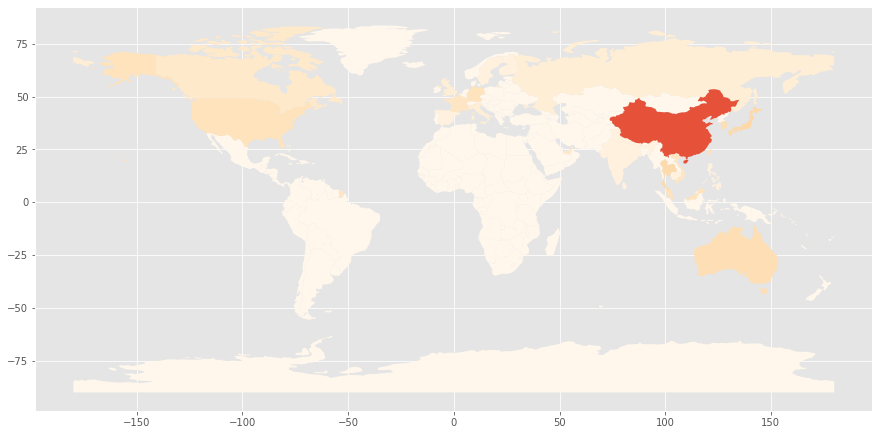

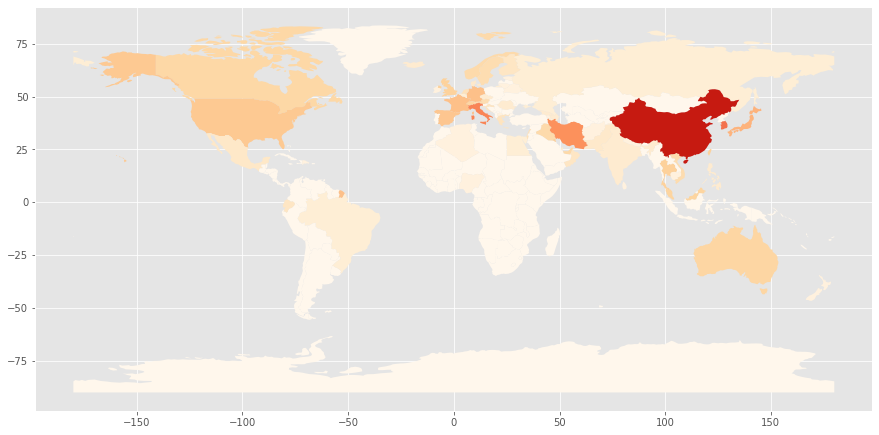

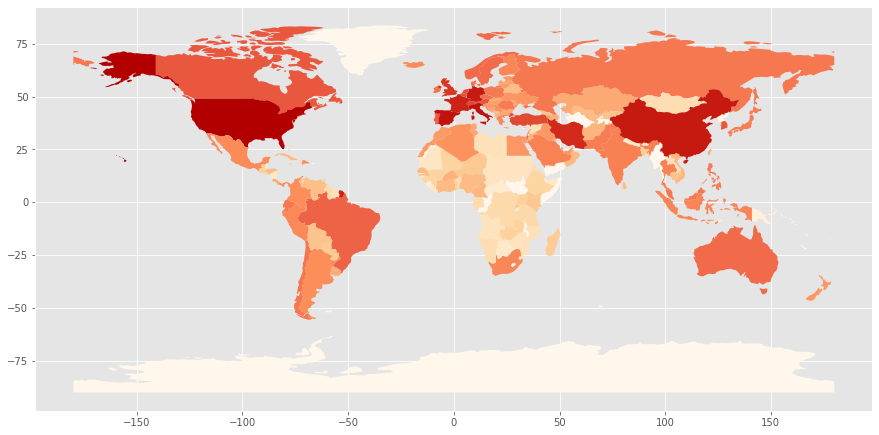

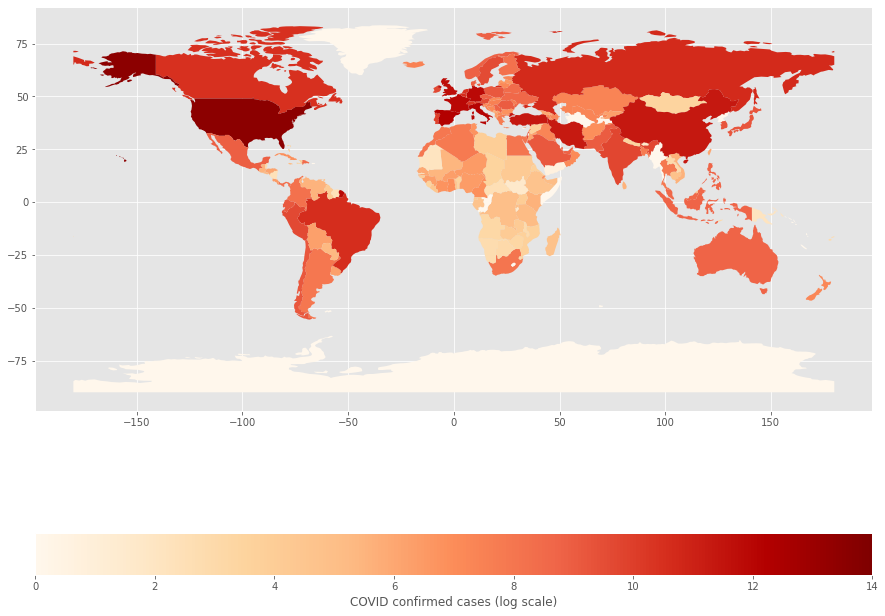

In [0]:
date = ['2020-02-01', '2020-03-01', '2020-04-01', df['Date'].max()]
for d in date:
    df_conf = df[df['Date'] == d][['Country/Region', 'Confirmed']].dropna().groupby('Country/Region').sum().reset_index()
    df_conf.columns = ['name', 'covid_confirmed']
    df_conf.replace({'Western Sahara': 'W. Sahara', 'US': 'United States of America', 'Congo (Brazzaville)': 'Dem. Rep. Congo',
                    'Dominican Republic': 'Dominican Rep.', 'Cote d\'Ivoire': 'Côte d\'Ivoire', 'Central African Republic': 'Central African Rep.',
                    'Congo (Brazzaville)': 'Dem. Rep. Congo', 'Equatorial Guinea': 'Eq. Guinea', 'Eswatini': 'eSwatini', 'Korea, South': 'South Korea',
                    'Taiwan*': 'Taiwan', 'Cyprus': 'N. Cyprus', 'Bosnia and Herzegovina': 'Bosnia and Herz.',
                    'North Macedonia': 'Macedonia', 'South Sudan': 'S. Sudan', 'Somalia': 'Somaliland'}, inplace=True)
    world2 = world.join(df_conf.set_index('name'), on='name', how='left')
    world2['log_confirmed'] = np.log(1 + world2['covid_confirmed']).fillna(0)
    world2.plot(column='log_confirmed', colormap='OrRd', vmin=0, vmax=14);

sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=14))
sm._A = []
plt.colorbar(sm, orientation="horizontal", label="COVID confirmed cases (log scale)");

# Greenland, Falkland Is., New Caledonia	, 'Congo (Brazzaville)': 'Congo'

**Вывод:**

По карте распространения болезни видно, что Китай был источником вируса. 2 месяца ситация развивалась не так сильно (ухудшение наблюдалось в Италии, Южной Корее и Иране), но потом начался резкий рост числа зараженных. Сейчас особо страдает США и Европа. Для наглядности шкала раскраски представлена в логарифмическом масштабе.

#### 1.2 Определите количество стран, которые подтвердили случаи заражения. Визуализируйте рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

In [0]:
df1 = df[['Date', 'Country/Region', 'Confirmed']].groupby(['Date', 'Country/Region']).sum().reset_index()
df2 = df1[df1['Confirmed'] != 0].groupby(['Date']).count().reset_index()[['Date', 'Country/Region']]

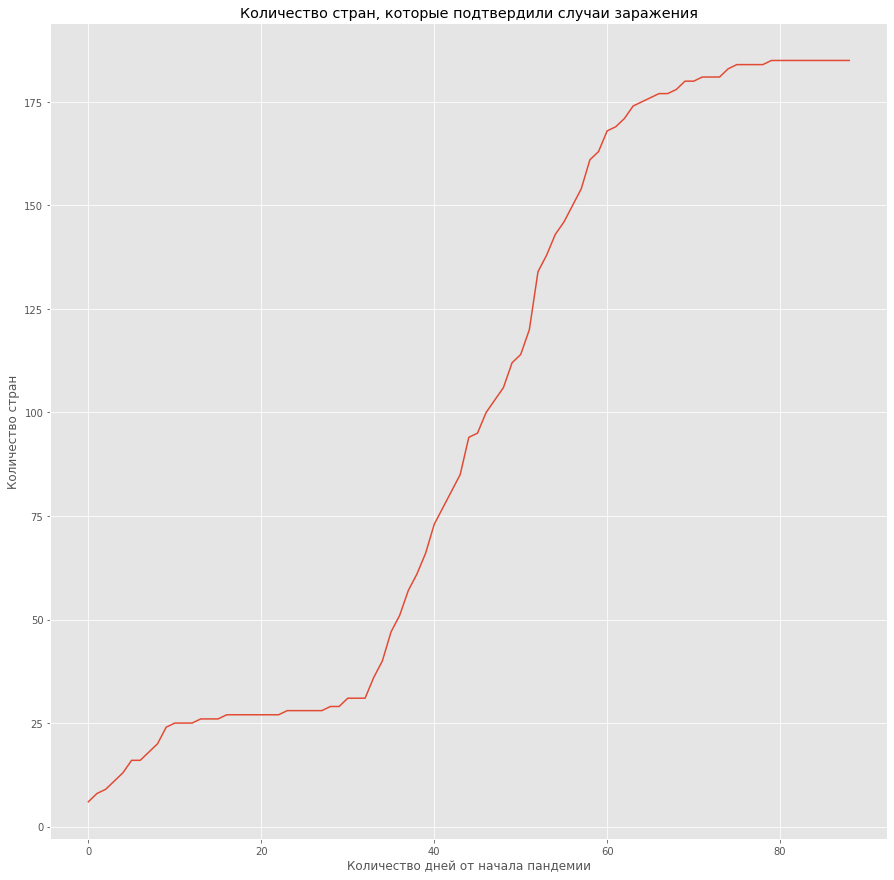

In [0]:
plt.plot(df2['Country/Region'])
plt.title('Количество стран, которые подтвердили случаи заражения')
plt.ylabel('Количество стран')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

**Вывод:**

Сначала лишь небольшое количество стран подтвердило случаи заражения, затем, спустя почти 20 дней неизменного количества (как раз инкубационный период 14 дней) начинается резкий рост количества стран, подтвердивших случаи заражения. Сейчас все страны подтвердили наличие зараженных.

#### 1.3 Визуализируйте мировые тренды по числу заболевших | погибших | выздоровивших. Постройте графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

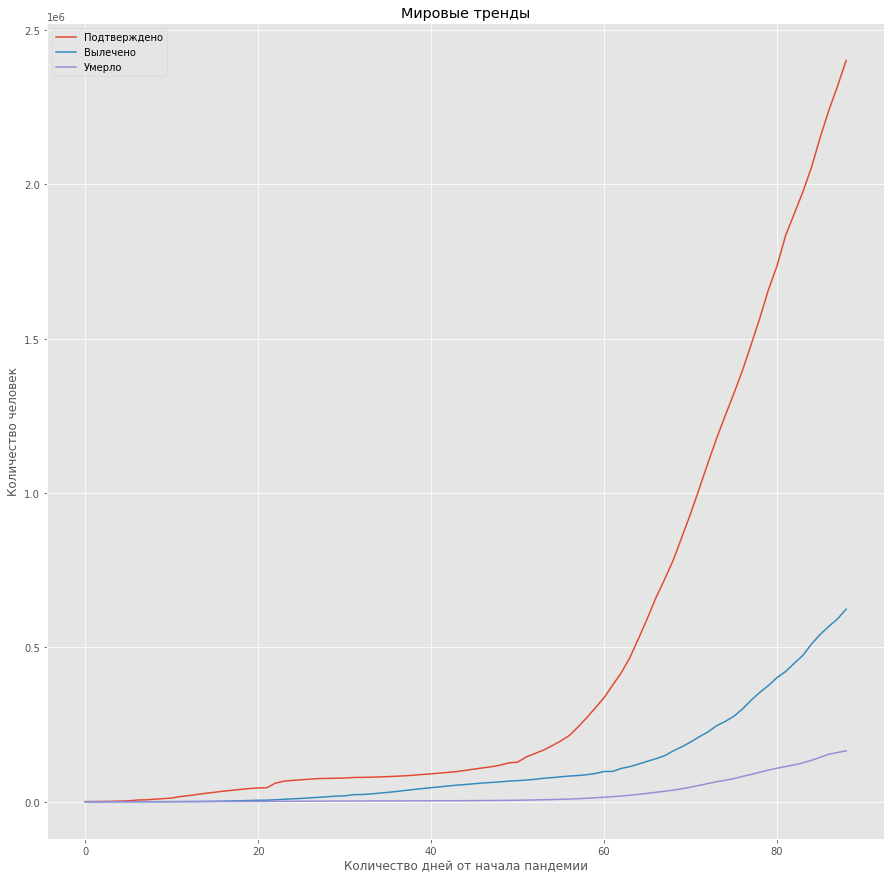

In [0]:
df3 = df[['Date', 'Confirmed']].groupby(['Date']).sum().reset_index()
df4 = df[['Date', 'Recovered']].groupby(['Date']).sum().reset_index()
df5 = df[['Date', 'Deaths']].groupby(['Date']).sum().reset_index()

plt.plot(df3['Confirmed'], label='Подтверждено')
plt.plot(df4['Recovered'], label='Вылечено')
plt.plot(df5['Deaths'], label='Умерло')
plt.legend()
plt.title('Мировые тренды')
plt.ylabel('Количество человек')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

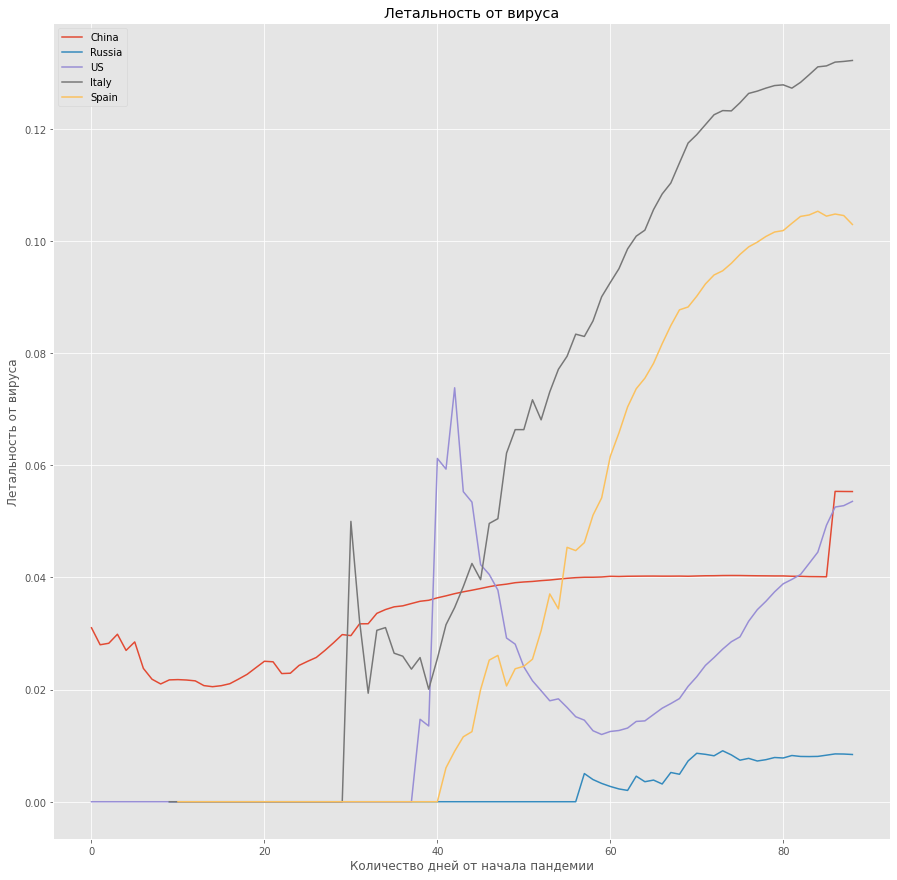

In [0]:
df6 = df[['Date', 'Country/Region', 'Confirmed', 'Deaths']].groupby(['Date', 'Country/Region']).sum().reset_index()
df6['mort_rate'] = df6['Deaths'] / df6['Confirmed']

for con in ['China', 'Russia', 'US', 'Italy', 'Spain']:
    tmp_df = df6[df6['Country/Region'] == con]['mort_rate']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Летальность от вируса')
plt.ylabel('Летальность от вируса')
plt.xlabel('Количество дней от начала пандемии')
plt.show()


**Вывод:**

Мировые тренды роста описывают тренды роста в большинстве стран. Заметный рост числа зараженных начинается с 5го дня, а резкий рост с 50-го. Рост выздоровевших начинается с 20-го дня, а рост смертей с 60-го.

В разных странах абсолютно разная летальность от вируса (количество смертей / количество всех зараженных). В Китае слабо изменяющийся показатель, в России это значение только начинает расти (но растет не резко). Хуже всего ситуация по летальности в Италии. В Испании рост чуть меньше, чем в Италии. У Италии и США наблюдается резкий скачок летальности с начала учета количества зараженных.

#### 1.4 Визуализируйте и сравните, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определите количество дней для каждой страны со дня первого зарегестрированного случая.

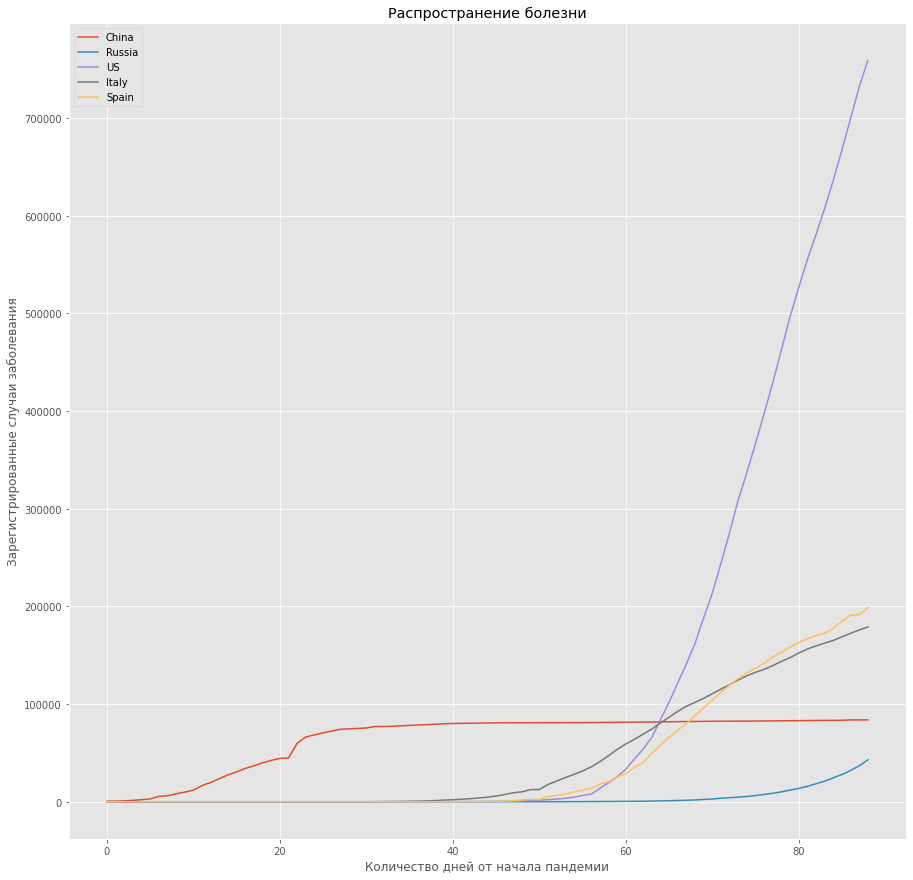

In [0]:
for con in ['China', 'Russia', 'US', 'Italy', 'Spain']:
    tmp_df = df1[df1['Country/Region'] == con]['Confirmed']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Распространение болезни')
plt.ylabel('Зарегистрированные случаи заболевания')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

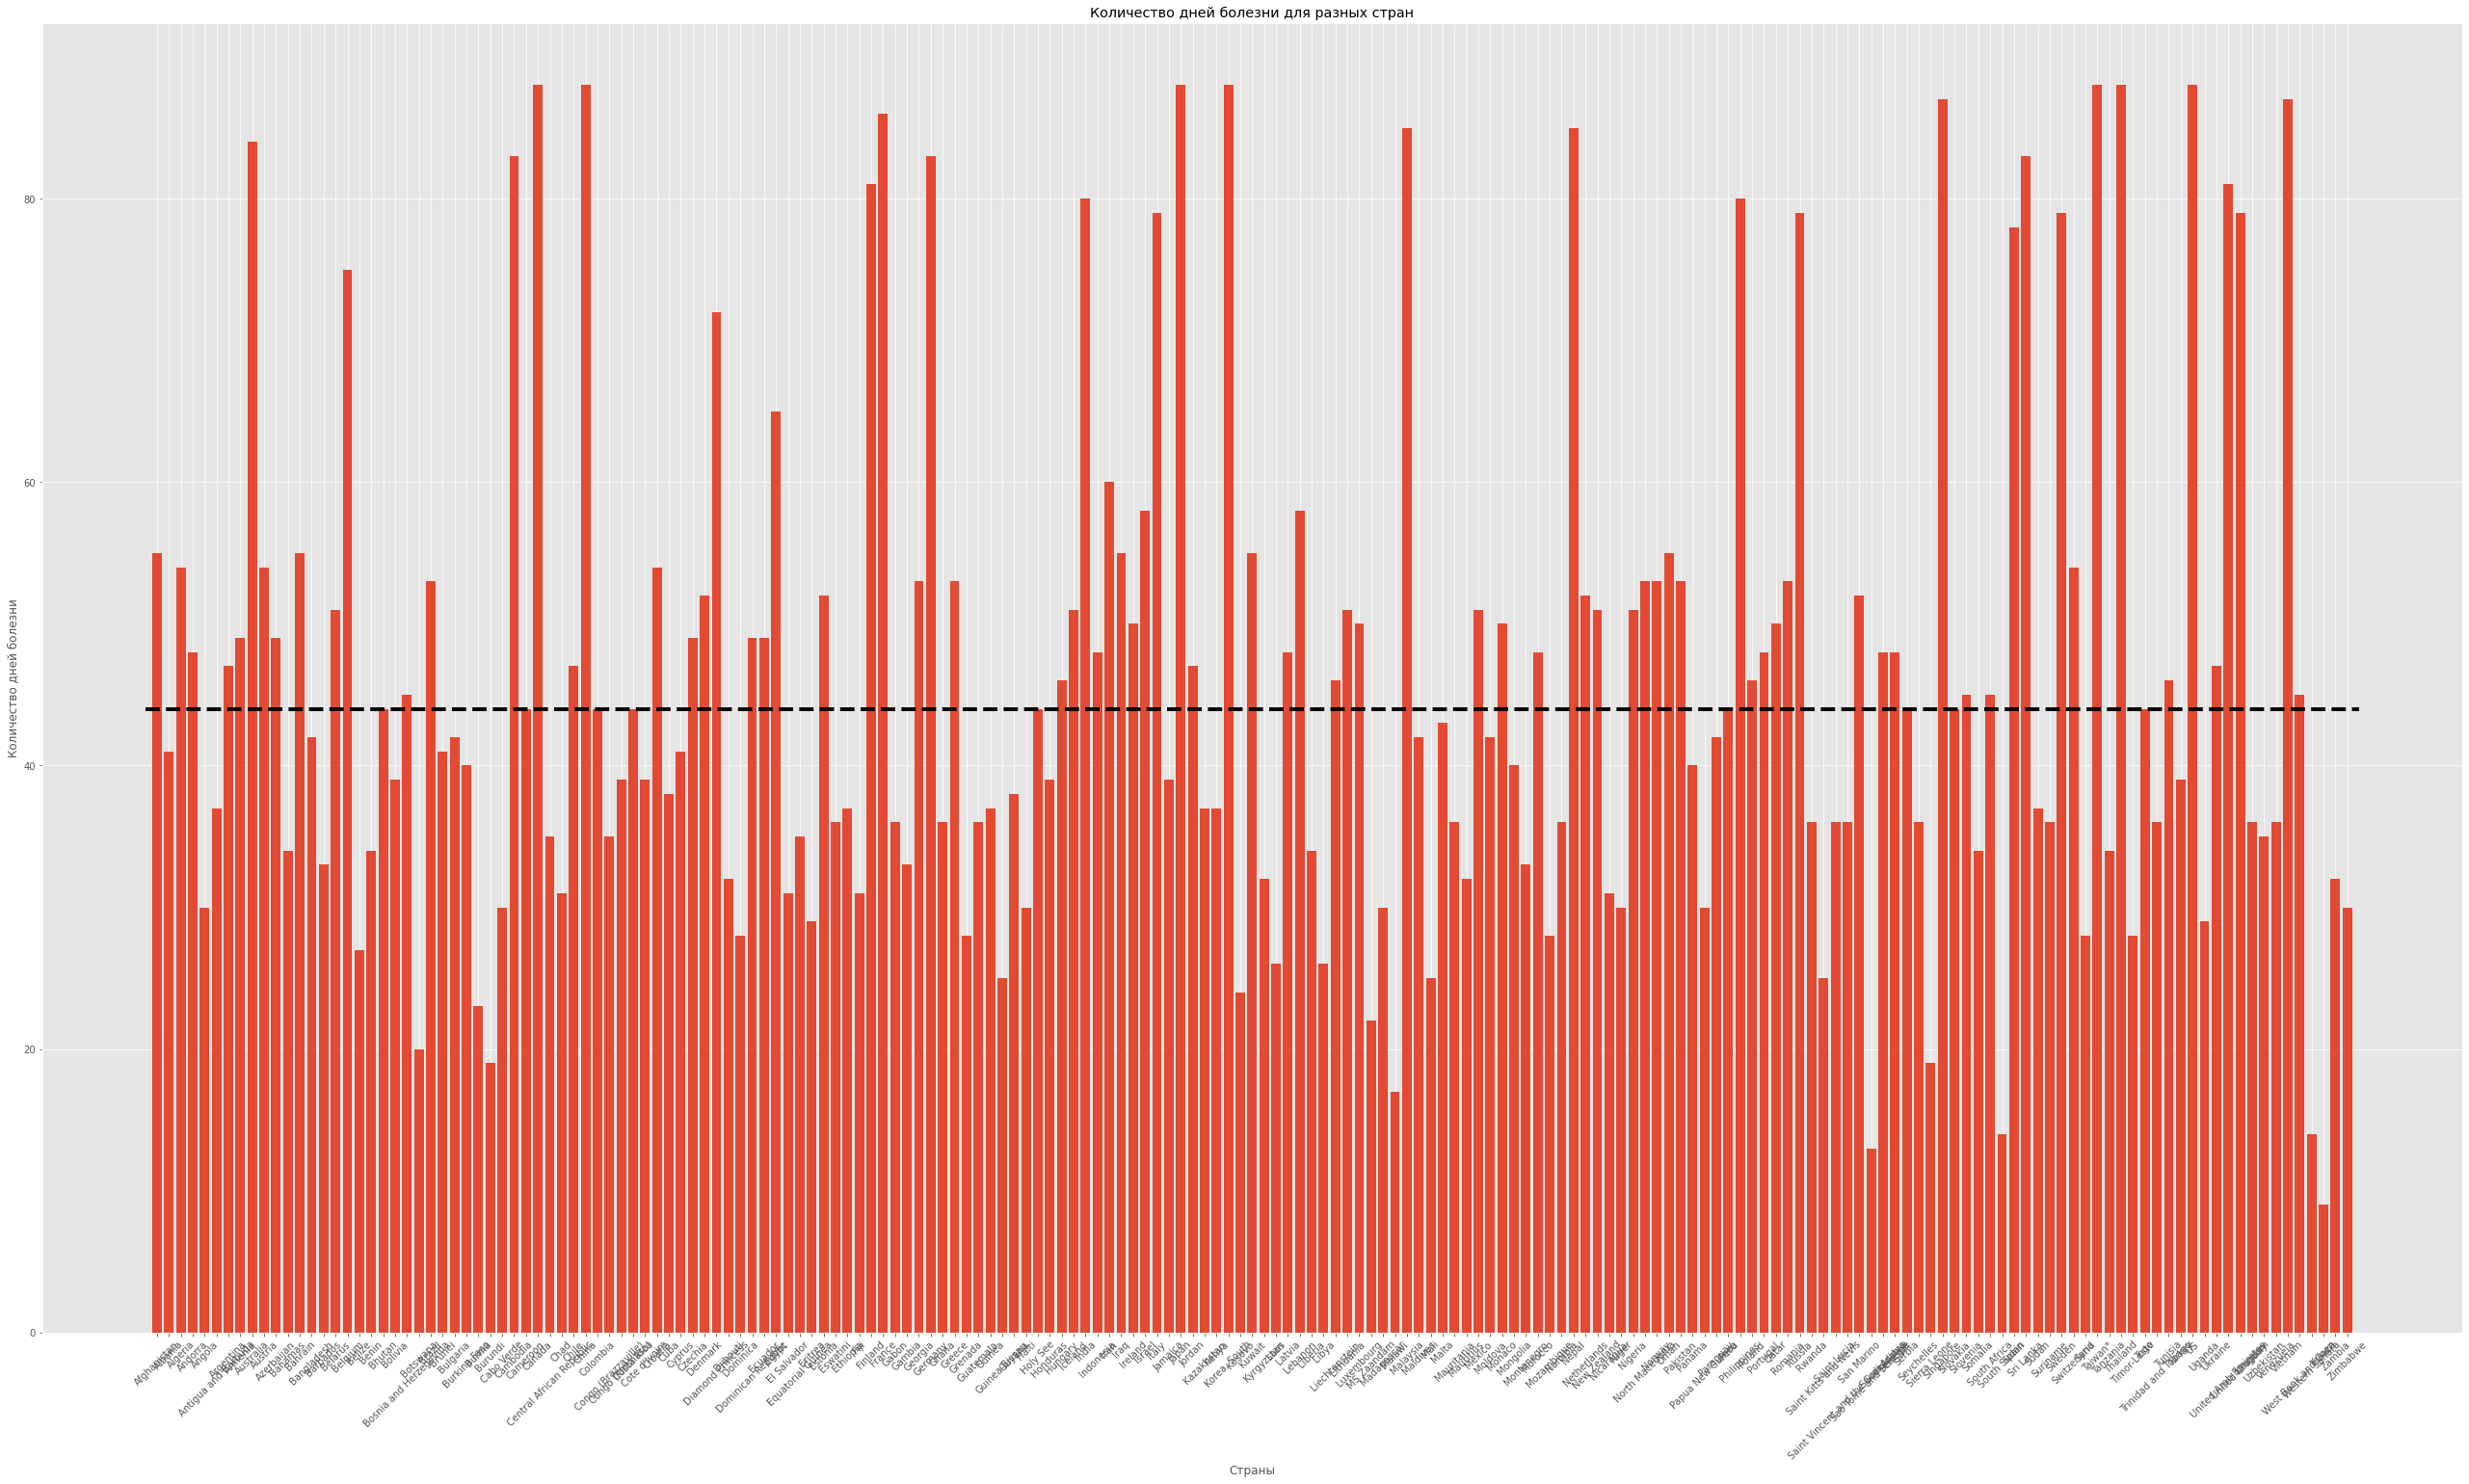

In [0]:
dm = dt.datetime.strptime(df['Date'].max(), '%Y-%m-%d')
tt = lambda x: (dm - dt.datetime.strptime(x, '%Y-%m-%d')).days
df_days = df[df['Confirmed'] != 0][['Date', 'Country/Region']].groupby(['Country/Region']).min().reset_index()
df_days['Date'] = df_days['Date'].apply(tt)
plt.figure(figsize=(45, 25))
plt.hlines(df_days['Date'].median(), -1, 185, linestyles='--', lw=4)
plt.title('Количество дней болезни для разных стран')
plt.ylabel('Количество дней болезни')
plt.xlabel('Страны')
plt.xticks(rotation=45)
plt.bar(df_days['Country/Region'], df_days['Date']);

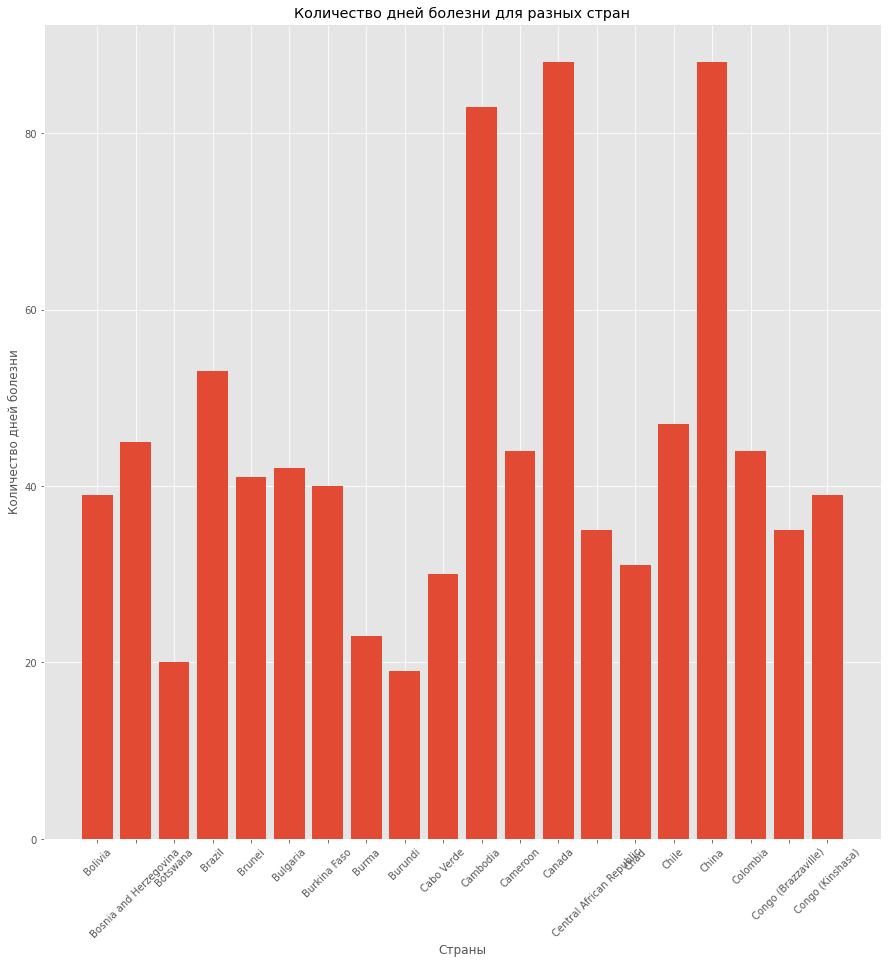

In [0]:
plt.title('Количество дней болезни для разных стран')
plt.ylabel('Количество дней болезни')
plt.xlabel('Страны')
plt.xticks(rotation=45)
plt.bar(df_days['Country/Region'][20:40], df_days['Date'][20:40]);

**Вывод:**

В разных странах болезнь распространялась разными темпами, рост начинался в разные дни. По графику видно, что первыми начали расти темпы в Китае. Хуже всего ситуация развивается в США. Китай уже пережил пик пандемии, т.к. количество новых случаев не изменяется. В это же время в остальных странах все еще наблюдается рост.

Медианное число дней болезни - 45. Всего 15 стран лидируют по количеству дней болезни (больше 80).

#### 1.5 Визуализируйте и оцените как развивалась ситуация в России по сравнению с остальными миром.

In [0]:
print('COVID-19 в России уже', df_days[df_days['Country/Region'] == 'Russia']['Date'].values[0], 'дней')
print('COVID-19 в мире уже', (dm - dt.datetime.strptime(df['Date'].min(), '%Y-%m-%d')).days, 'дней')

COVID-19 в России уже 79 дней
COVID-19 в мире уже 88 дней


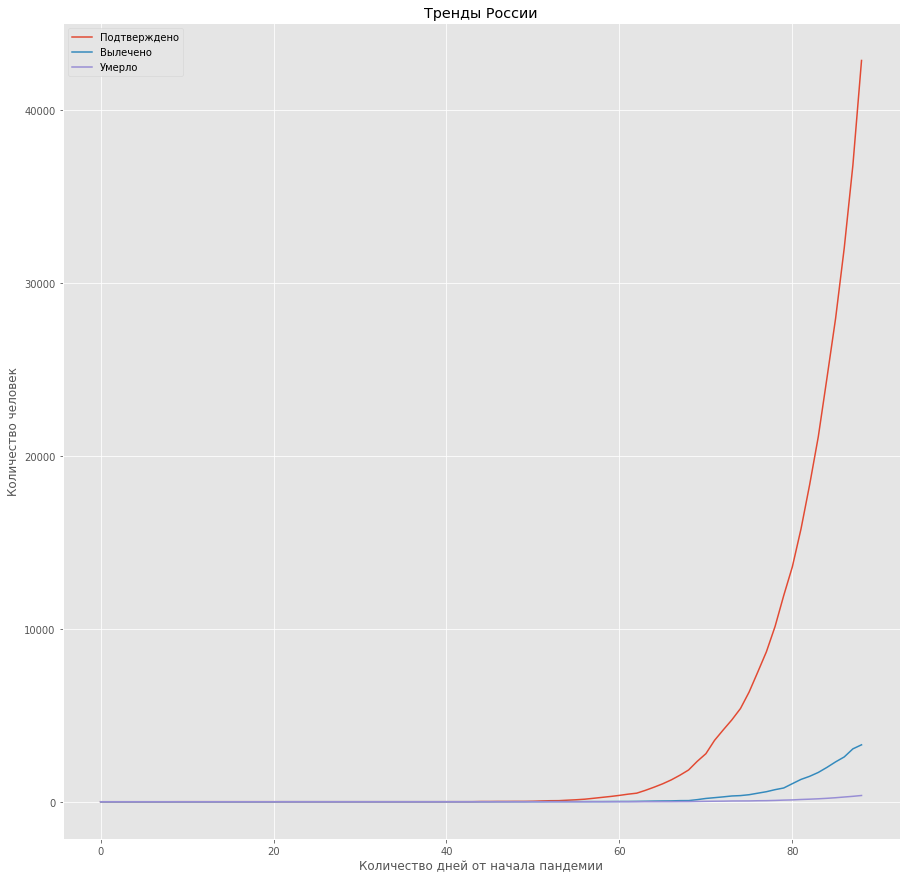

In [0]:
df_rus = df[df['Country/Region'] == 'Russia'][['Date', 'Confirmed', 'Recovered', 'Deaths']].groupby(['Date']).sum().reset_index()

plt.plot(df_rus['Confirmed'], label='Подтверждено')
plt.plot(df_rus['Recovered'], label='Вылечено')
plt.plot(df_rus['Deaths'], label='Умерло')
plt.legend()
plt.title('Тренды России')
plt.ylabel('Количество человек')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

**Вывод:**

России долгое время удавалось сдерживать рост пандемии. Первый заболевший появился спустя 9 дней после начала отсчета. Но резкий рост числа подтвержденных случаев начинается с 50-го дня. С 70 дня начинается более плавный рост числа вылеченных (это значит, что лечение занимает немного меньше 20 дней), но рост не такой резкий, как для подтвержденных случаев - это значит, что многие еще болеют и болезнь в общем случа длится долго. Начиная с 80-го дня начинается небольшой рост смертности.

В сопоставлении с общемировыми показателями. Начало роста подтвержденных случает заражения - 5, начало роста выздоровевших - 20, начало роста смертельных случаев - 50.

#### 1.6 Определите топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравните насколько быстро развивается ситуация в этих странах, определите корреляцию.

In [0]:
stat = df[df['Date'] == df['Date'].max()][['Country/Region', 'Confirmed', 'Recovered', 'Deaths']].groupby('Country/Region').sum().reset_index()
stat_conf = stat.sort_values('Confirmed', ascending=False)['Country/Region'][:10].values
stat_rec = stat.sort_values('Recovered', ascending=False)['Country/Region'][:10].values
stat_dth = stat.sort_values('Deaths', ascending=False)['Country/Region'][:10].values
print('Топ-10 стран по количеству случаев заражения:', stat_conf)
print('Топ-10 стран по количеству случаев выздоровления:', stat_rec)
print('Топ-10 стран по количеству случаев смерти:', stat_dth)

Топ-10 стран по количеству случаев заражения: ['US' 'Spain' 'Italy' 'France' 'Germany' 'United Kingdom' 'Turkey' 'China'
 'Iran' 'Russia']
Топ-10 стран по количеству случаев выздоровления: ['Germany' 'China' 'Spain' 'US' 'Iran' 'Italy' 'France' 'Brazil'
 'Switzerland' 'Turkey']
Топ-10 стран по количеству случаев смерти: ['US' 'Italy' 'Spain' 'France' 'United Kingdom' 'Belgium' 'Iran' 'China'
 'Germany' 'Netherlands']


In [0]:
stat['total'] = stat['Confirmed'] + stat['Recovered'] + stat['Deaths']
stat_tot = stat.sort_values('total', ascending=False)['Country/Region'][:10].values
print('Топ-10 стран по сумме всех показателей:', stat_tot)

Топ-10 стран по сумме всех показателей: ['US' 'Spain' 'Italy' 'Germany' 'France' 'China' 'Iran' 'United Kingdom'
 'Turkey' 'Brazil']


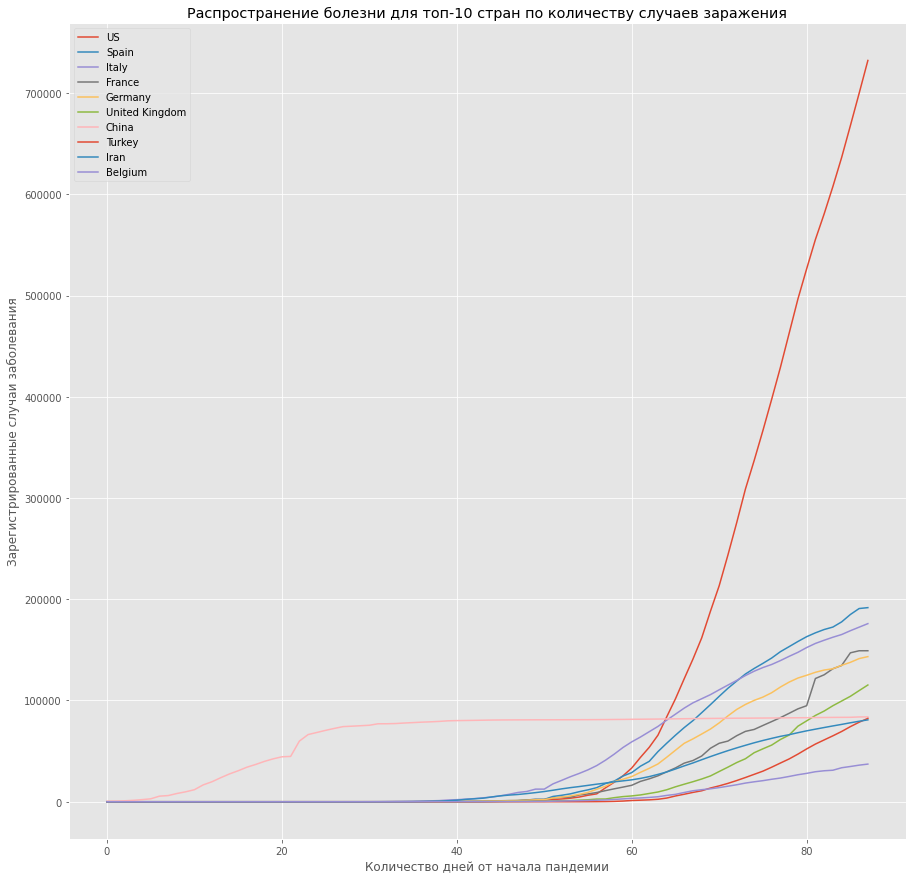

In [0]:
for con in stat_conf:
    tmp_df = df1[df1['Country/Region'] == con]['Confirmed']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Распространение болезни для топ-10 стран по количеству случаев заражения')
plt.ylabel('Зарегистрированные случаи заболевания')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

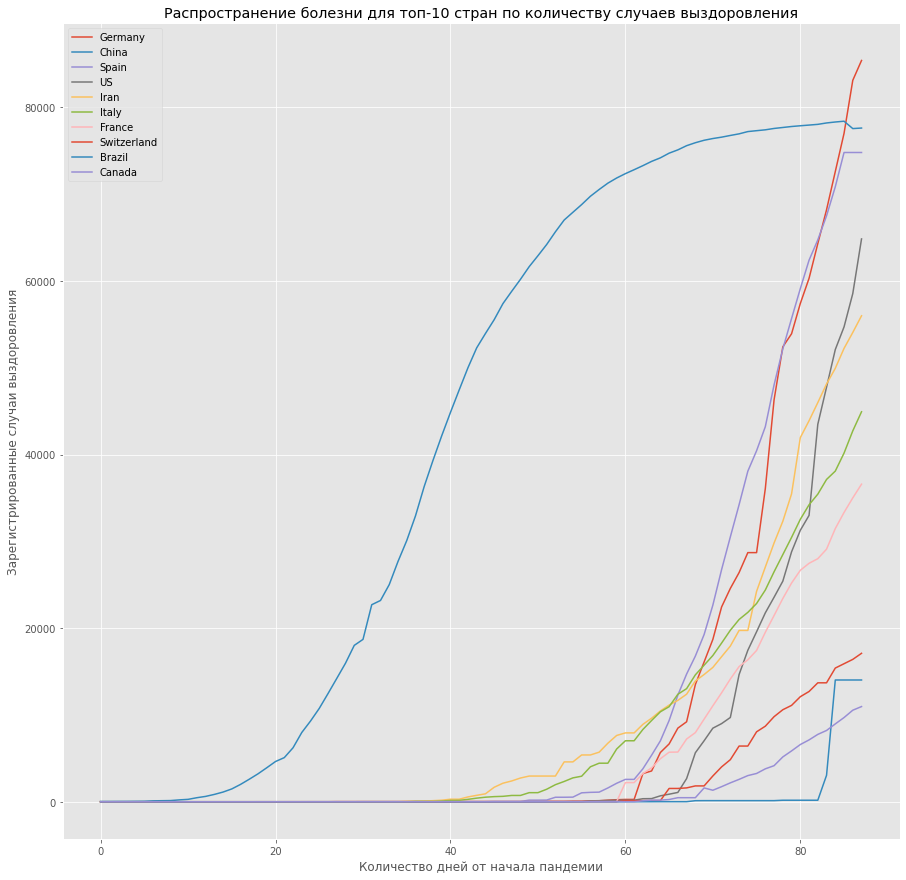

In [0]:
df7 = df[['Date', 'Country/Region', 'Recovered']].groupby(['Date', 'Country/Region']).sum().reset_index()
for con in stat_rec:
    tmp_df = df7[df7['Country/Region'] == con]['Recovered']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Распространение болезни для топ-10 стран по количеству случаев выздоровления')
plt.ylabel('Зарегистрированные случаи выздоровления')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

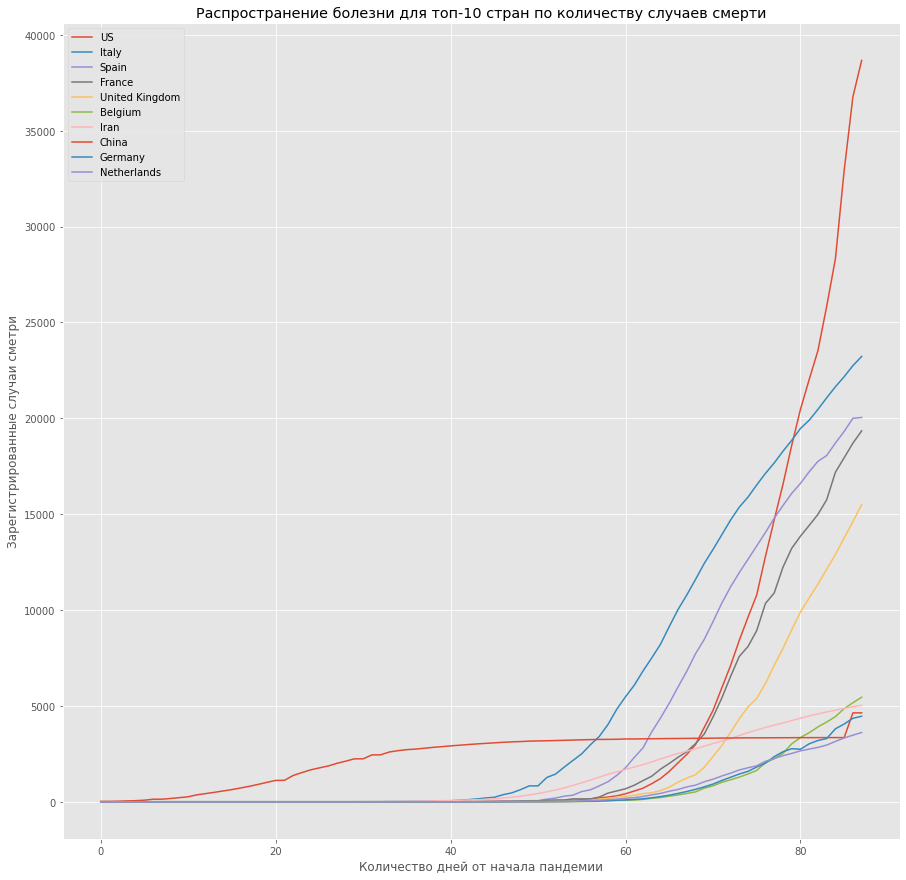

In [0]:
df8 = df[['Date', 'Country/Region', 'Deaths']].groupby(['Date', 'Country/Region']).sum().reset_index()
for con in stat_dth:
    tmp_df = df8[df8['Country/Region'] == con]['Deaths']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Распространение болезни для топ-10 стран по количеству случаев смерти')
plt.ylabel('Зарегистрированные случаи сметри')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

In [0]:
stat_all = set(stat_conf) | set(stat_rec) | set(stat_dth)
df8 = df[(df['Date'] == df['Date'].max()) & (df['Country/Region'].isin(list(stat_all)))][['Country/Region', 'Confirmed', 'Recovered', 'Deaths']].groupby('Country/Region').sum().reset_index()
print("Коэффициент корреляции случаев заражения и выздоровления:", np.corrcoef(df8['Confirmed'], df8['Recovered'])[0,1], 
      "Коэффициент корреляции случаев заражения и смерти:", np.corrcoef(df8['Confirmed'], df8['Deaths'])[0,1], 
      "Коэффициент корреляции случаев выздоровления и смерти:", np.corrcoef(df8['Recovered'], df8['Deaths'])[0,1], sep='\n'
      )

Коэффициент корреляции случаев заражения и выздоровления:
0.4634668802307063
Коэффициент корреляции случаев заражения и смерти:
0.8754005669546233
Коэффициент корреляции случаев выздоровления и смерти:
0.39374328890816884


In [0]:
df9 = df[df['Country/Region'].isin(list(stat_all))][['Date', 'Country/Region', 'Confirmed', 'Recovered', 'Deaths']].groupby(['Date', 'Country/Region']).sum().reset_index()
df_stat_conf = pd.DataFrame(index = stat_conf, columns = stat_conf)
for c in stat_conf:
    for cc in stat_conf:
        df_stat_conf.loc[c, cc] = np.corrcoef(df9[df9['Country/Region'] == c]['Confirmed'], df9[df9['Country/Region'] == cc]['Confirmed'])[0,1]
df_stat_conf

US Spain Italy France  ... Turkey China Iran Russia
US             1.00  0.97  0.93   0.99  ...   0.99  0.36 0.95   0.93
Spain          0.97  1.00  0.99   0.98  ...   0.94  0.42 0.99   0.84
Italy          0.93  0.99  1.00   0.96  ...   0.89  0.48 1.00   0.79
France         0.99  0.98  0.96   1.00  ...   0.98  0.39 0.97   0.91
Germany        0.97  1.00  0.99   0.98  ...   0.93  0.43 0.99   0.83
United Kingdom 1.00  0.96  0.92   0.99  ...   1.00  0.36 0.94   0.94
Turkey         0.99  0.94  0.89   0.98  ...   1.00  0.33 0.91   0.96
China          0.36  0.42  0.48   0.39  ...   0.33  1.00 0.48   0.28
Iran           0.95  0.99  1.00   0.97  ...   0.91  0.48 1.00   0.81
Russia         0.93  0.84  0.79   0.91  ...   0.96  0.28 0.81   1.00

[10 rows x 10 columns]

In [0]:
df_stat_rec = pd.DataFrame(index = stat_rec, columns = stat_rec)
for c in stat_rec:
    for cc in stat_rec:
        df_stat_rec.loc[c, cc] = np.corrcoef(df9[df9['Country/Region'] == c]['Recovered'], df9[df9['Country/Region'] == cc]['Recovered'])[0,1]
df_stat_rec

Germany China Spain   US  ... France Brazil Switzerland Turkey
Germany        1.00  0.55  0.99 0.98  ...   0.99   0.74        1.00   0.91
China          0.55  1.00  0.59 0.49  ...   0.59   0.28        0.54   0.40
Spain          0.99  0.59  1.00 0.96  ...   1.00   0.67        0.99   0.87
US             0.98  0.49  0.96 1.00  ...   0.97   0.82        0.98   0.96
Iran           0.99  0.64  0.99 0.97  ...   0.99   0.71        0.98   0.89
Italy          0.98  0.67  0.99 0.95  ...   0.99   0.67        0.97   0.86
France         0.99  0.59  1.00 0.97  ...   1.00   0.69        0.99   0.88
Brazil         0.74  0.28  0.67 0.82  ...   0.69   1.00        0.72   0.92
Switzerland    1.00  0.54  0.99 0.98  ...   0.99   0.72        1.00   0.90
Turkey         0.91  0.40  0.87 0.96  ...   0.88   0.92        0.90   1.00

[10 rows x 10 columns]

In [0]:
df_stat_dth = pd.DataFrame(index = stat_dth, columns = stat_dth)
for c in stat_dth:
    for cc in stat_dth:
        df_stat_dth.loc[c, cc] = np.corrcoef(df9[df9['Country/Region'] == c]['Deaths'], df9[df9['Country/Region'] == cc]['Deaths'])[0,1]
df_stat_dth

US Italy Spain France  ... Iran China Germany Netherlands
US             1.00  0.89  0.93   0.98  ... 0.86  0.49    0.99        0.97
Italy          0.89  1.00  0.99   0.95  ... 1.00  0.61    0.93        0.97
Spain          0.93  0.99  1.00   0.98  ... 0.97  0.56    0.97        0.99
France         0.98  0.95  0.98   1.00  ... 0.92  0.52    1.00        1.00
United Kingdom 1.00  0.91  0.95   0.99  ... 0.88  0.49    1.00        0.98
Belgium        1.00  0.90  0.94   0.99  ... 0.88  0.49    0.99        0.98
Iran           0.86  1.00  0.97   0.92  ... 1.00  0.65    0.91        0.95
China          0.49  0.61  0.56   0.52  ... 0.65  1.00    0.51        0.54
Germany        0.99  0.93  0.97   1.00  ... 0.91  0.51    1.00        0.99
Netherlands    0.97  0.97  0.99   1.00  ... 0.95  0.54    0.99        1.00

[10 rows x 10 columns]

In [0]:
df_stat_all = pd.DataFrame(index = stat_all, columns = ['Corr conf&recov', 'Corr conf&death', 'Corr recov&death'])
for c in stat_all:
    df_stat_all.loc[c, 'Corr conf&recov'] = np.corrcoef(df9[df9['Country/Region'] == c]['Confirmed'], df9[df9['Country/Region'] == c]['Recovered'])[0,1]
    df_stat_all.loc[c, 'Corr conf&death'] = np.corrcoef(df9[df9['Country/Region'] == c]['Confirmed'], df9[df9['Country/Region'] == c]['Deaths'])[0,1]
    df_stat_all.loc[c, 'Corr recov&death'] = np.corrcoef(df9[df9['Country/Region'] == c]['Recovered'], df9[df9['Country/Region'] == c]['Deaths'])[0,1]
df_stat_all

Corr conf&recov Corr conf&death Corr recov&death
Germany                   0.94            0.94             1.00
Belgium                   0.99            0.97             0.99
Italy                     0.97            1.00             0.99
Switzerland               0.90            0.96             0.99
US                        0.97            0.97             1.00
Iran                      0.96            1.00             0.95
Spain                     0.97            1.00             0.99
France                    0.99            0.99             1.00
Turkey                    0.93            1.00             0.94
Brazil                    0.78            0.99             0.83
United Kingdom            0.92            0.99             0.89
Russia                    1.00            1.00             1.00
China                     0.81            0.94             0.92
Netherlands               0.95            0.99             0.94

Набор топ-10 стран по всем 3 показателям везде примерно одинаковый (всего разнообразных стран 14). 

По графиками видно, что большинство стран примерно схожи по темпу роста (у многих стран угол наклона совпадает).

Я построила коэффициенты корреляции для каждой комбинации показателей для всех стран за последнюю дату, чтобы оценить общемировую тенденцию. Коэффициент корреляции случаев заражения и смерти пока максимальный.

Далее для каждого показателя и соответсвующего ему топ-10 странам построила матрицу корреляции на данных за все время пандемии. Многие страны похожи друг на друга. Китай больше всего отличается, ведь он уже прошел пик пандемии. 

Далее по каждой стране (хотя бы из одного топа) за все время построила корреляцию весх комбинаций показателей, чтобы оценить ситуацию в конкретной стране.

1.7 Для первых 5 стран из топ-10 и России постойте сравнительные графики. Изучите как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей, ваш вариант...

In [0]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est  ...                                           geometry
0     920938  ...  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...
1   53950935  ...  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...
2     603253  ...  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3   35623680  ...  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...
4  326625791  ...  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...

[5 rows x 6 columns]

In [0]:
world.replace({'United States of America': 'US'}, inplace=True)
pop_est = world[world['name'].isin(stat5)][['pop_est', 'name']]
pop_est.columns = ['pop_est', 'Country/Region']
df10 = df10.join(pop_est.set_index('Country/Region'), on='Country/Region', how='left')

In [0]:
stat5 = np.append(stat_tot[:6], 'Russia')
df10 = df[df['Country/Region'].isin(stat5)][['Date', 'Country/Region', 'Confirmed', 'Recovered', 'Deaths']].groupby(['Date', 'Country/Region']).sum().reset_index()
world.replace({'United States of America': 'US'}, inplace=True)
pop_est = world[world['name'].isin(stat5)][['pop_est', 'name']]
pop_est.columns = ['pop_est', 'Country/Region']
df10 = df10.join(pop_est.set_index('Country/Region'), on='Country/Region', how='left')
df10['death/recov'] = df10['Deaths'] / df10['Recovered']
df10['death/conf'] = df10['Deaths'] / df10['Confirmed']
df10['conf/total'] = df10['Confirmed'] / df10['pop_est'] * 100

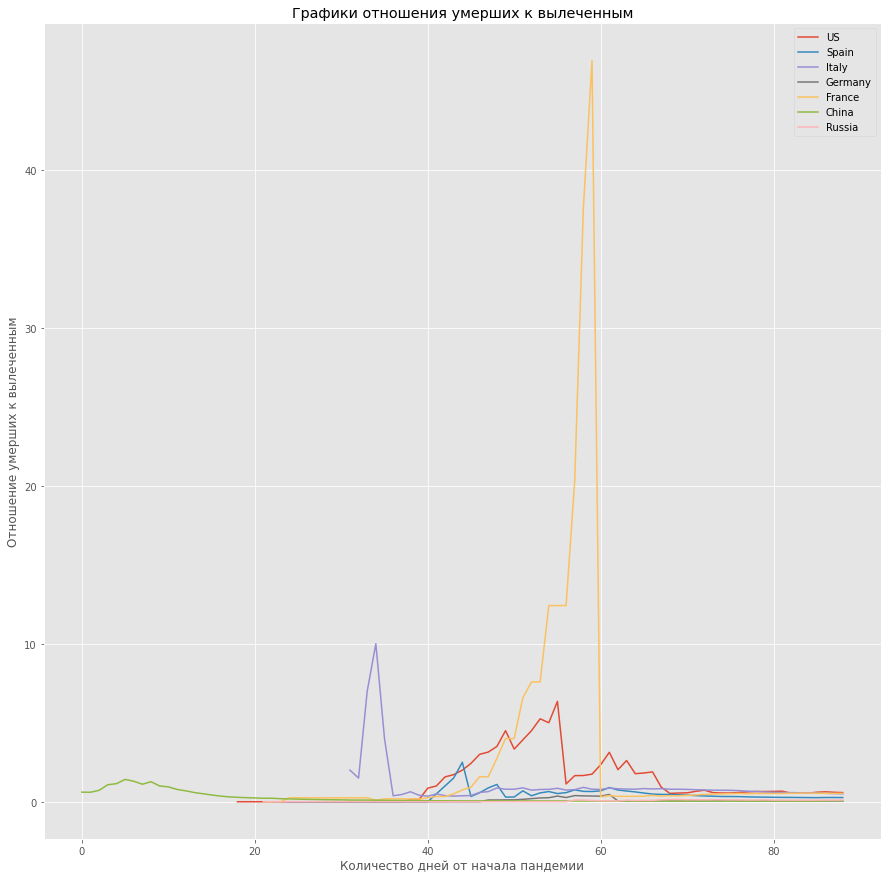

In [0]:
for con in stat5:
    tmp_df = df10[df10['Country/Region'] == con]['death/recov']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Графики отношения умерших к вылеченным')
plt.ylabel('Отношение умерших к вылеченным')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

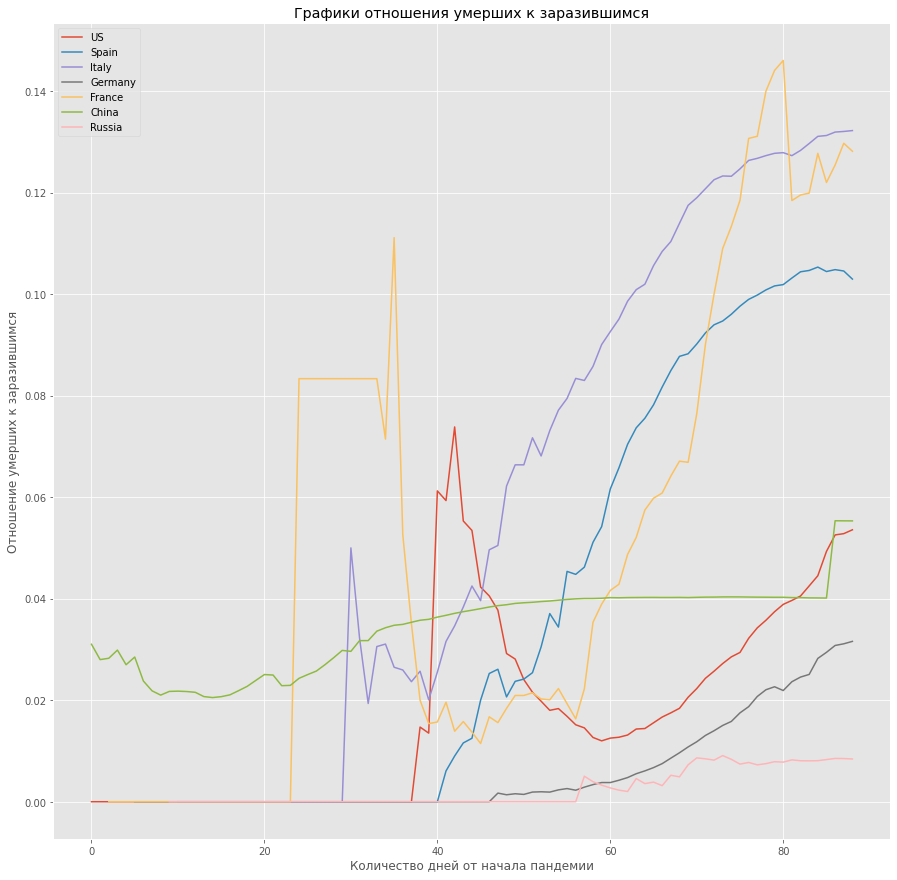

In [0]:
for con in stat5:
    tmp_df = df10[df10['Country/Region'] == con]['death/conf']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Графики отношения умерших к заразившимся')
plt.ylabel('Отношение умерших к заразившимся')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

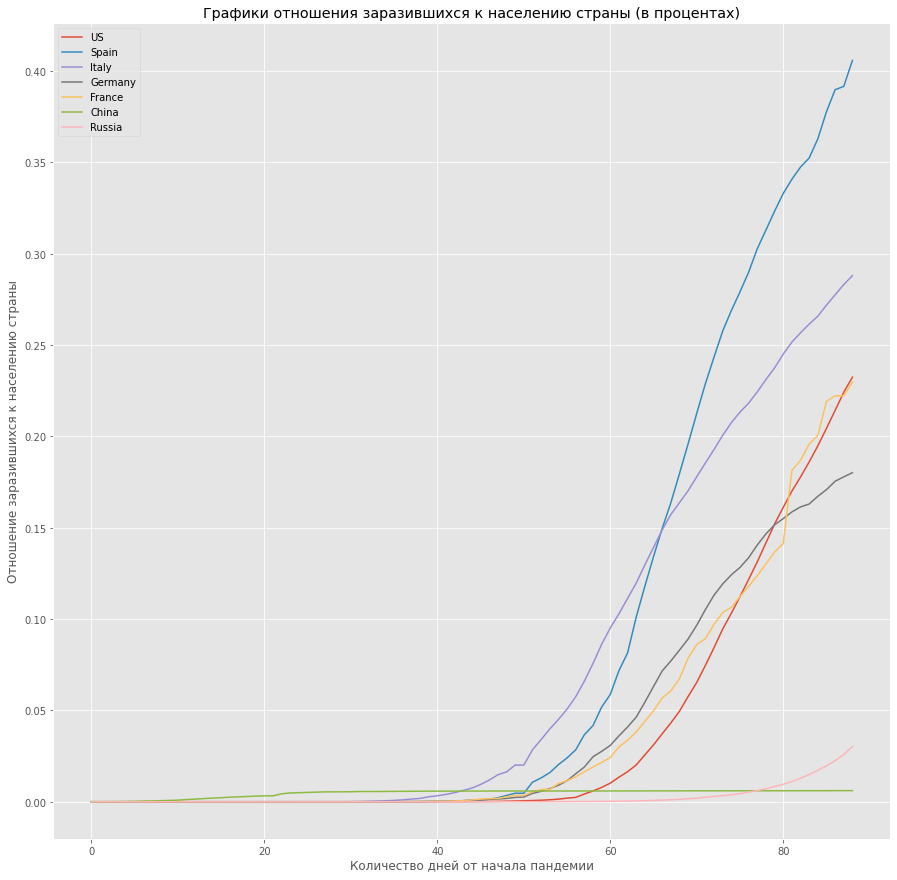

In [0]:
for con in stat5:
    tmp_df = df10[df10['Country/Region'] == con]['conf/total']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Графики отношения заразившихся к населению страны (в процентах)')
plt.ylabel('Отношение заразившихся к населению страны')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

График отношения умерших к вылеченнымв нормальном случае должен быть небольшой постоянной. У Франции наблюдается огромный скачок, у Италии, США и Испании этот показатель также далек от маленькой константы.

В графике зависимости умерших к заразившимся почти у всех стран наблюдается резкий скачок, а затем небольшой спад и рост. Нестабильнее всего ситуация во Франции. Лучше всего ситуация пока в России.

На нормированном на население страны графике заразившихся можно видеть реальную ситуацию в проенте от населения страны. Лучше всего ситуация в Китае (из-за большого количества населения) и России. Хуже всего в Испании и Италии (из-за маленькой числености населения). Остальные страны идут практически одинаково. 
Данный график более наглядный и отличается от обычного графика, построенного просто по количеству зараженных (графики масштабируются и меняется порядок стран).



1.8 Выделите временной ряд по одному из целевых признаков. Для выделенного временного ряда:
  - Представьте временной ряд в виде последовательности разницы между значениями. Рассчитайте лаги, выведите их на графике.
  - Попробуйте декомпозировать временной ряд. Постройте график тренда.
  - Что вы можете сказать о стационарности временного ряда? 

In [0]:
cnt = df['Country/Region'].nunique()
df11 = df[['Date', 'Country/Region', 'Confirmed']].groupby(['Date', 'Country/Region']).sum().reset_index()
df11['lag'] = df11['Confirmed'] - df11.shift(periods=cnt, fill_value=0)['Confirmed']

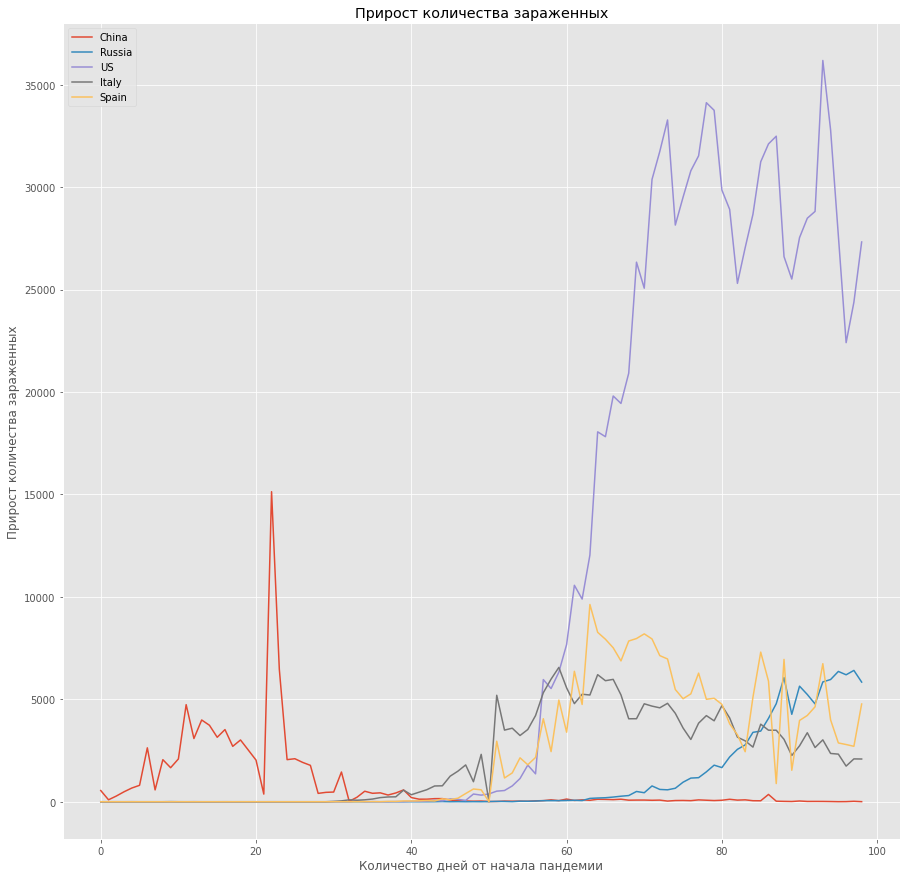

In [0]:
for con in ['China', 'Russia', 'US', 'Italy', 'Spain']:
    tmp_df = df11[df11['Country/Region'] == con]['lag']
    plt.plot(range(tmp_df.shape[0]), tmp_df, label=con)

plt.legend()
plt.title('Прирост количества зараженных')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

In [0]:
df11['Date'] = pd.DatetimeIndex(df11['Date'])
df11.index = pd.PeriodIndex(df11['Date'], freq='D')
df11.index = df11.index.to_timestamp()

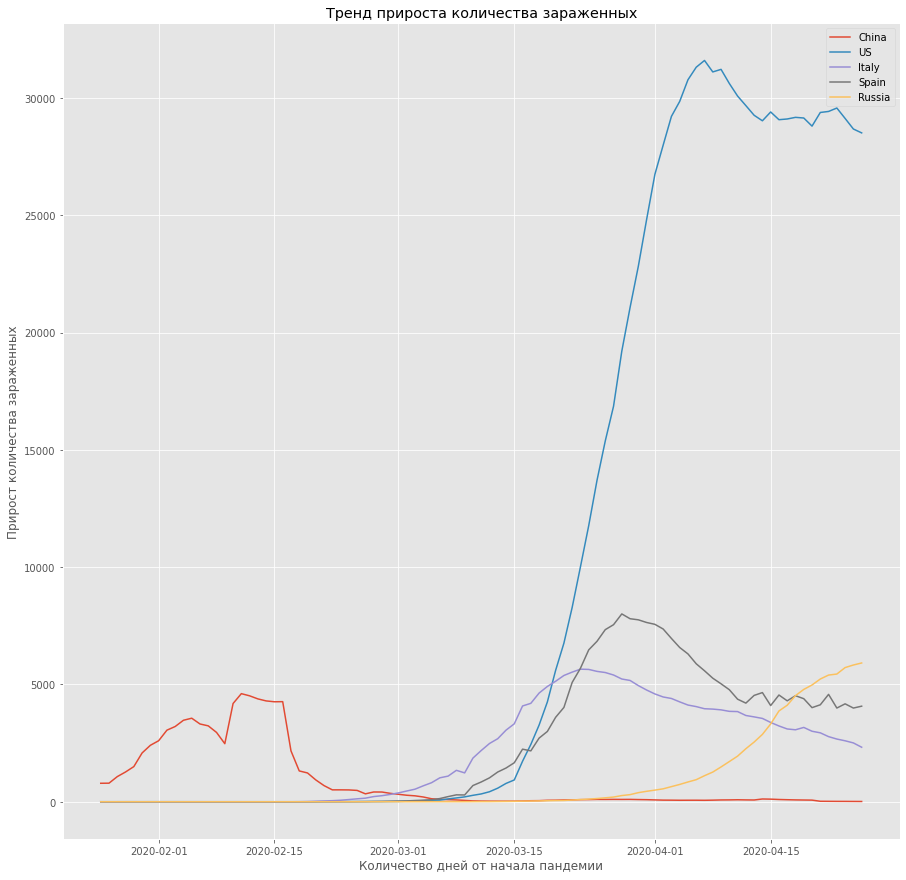

In [0]:
for con in ['China', 'US', 'Italy', 'Spain', 'Russia']:
    tmp_df = df11[df11['Country/Region'] == con]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=con)

plt.legend()
plt.title('Тренд прироста количества зараженных')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

In [0]:
#проверим ряд, например, для России
test = sma.tsa.adfuller(tmp_df['lag'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -2.4245122327117716
p-value:  0.13493718500356788
Critical values:  {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Есть единичные корни, ряд не стационарен


Временной ряд явно не стационарный (мат. ожидание не постоянно). 

По графикам видно, что тренд растет в России. В остальных странах тренд уже идет на спад. В Китае уже практически нет прироста.

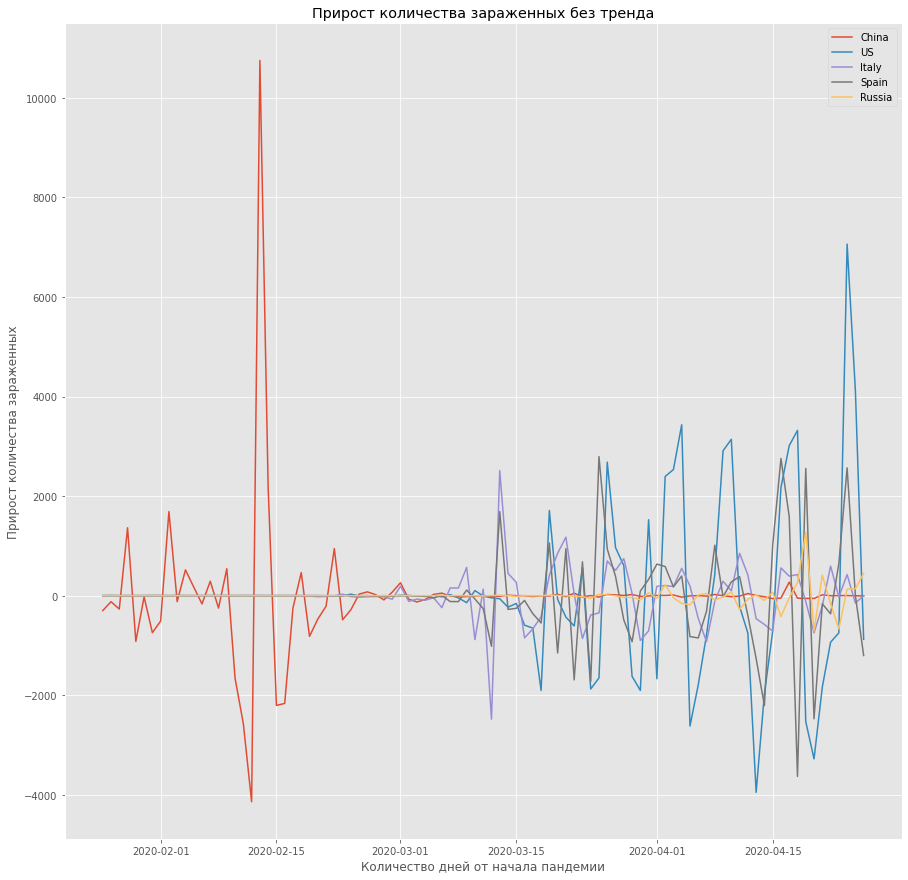

In [0]:
for con in ['China', 'US', 'Italy', 'Spain', 'Russia']:
    tmp_df = df11[df11['Country/Region'] == con]
    plt.plot((tmp_df['lag'] - seasonal_decompose(tmp_df['lag'], model='additive').trend), label=con)

plt.legend()
plt.title('Прирост количества зараженных без тренда')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Количество дней от начала пандемии')
plt.show()

In [0]:
#проверим ряд, например, для России
test = sma.tsa.adfuller((tmp_df['lag']- seasonal_decompose(tmp_df['lag'], model='additive').trend)[3:-3])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -1.7302245415813466
p-value:  0.41561099447801186
Critical values:  {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Есть единичные корни, ряд не стационарен


Если вычесть тренд, то ряд все равно остается нестационарным (мат. ожидание близко к константе, но дисперсия большая, амплитуда увеличивается), но уже близок к стационароному и с ним удобнее работать

1.9 Для любого интересующего Вас временного ряда постройте графики ACF и PACF. Сделайте выводы. 

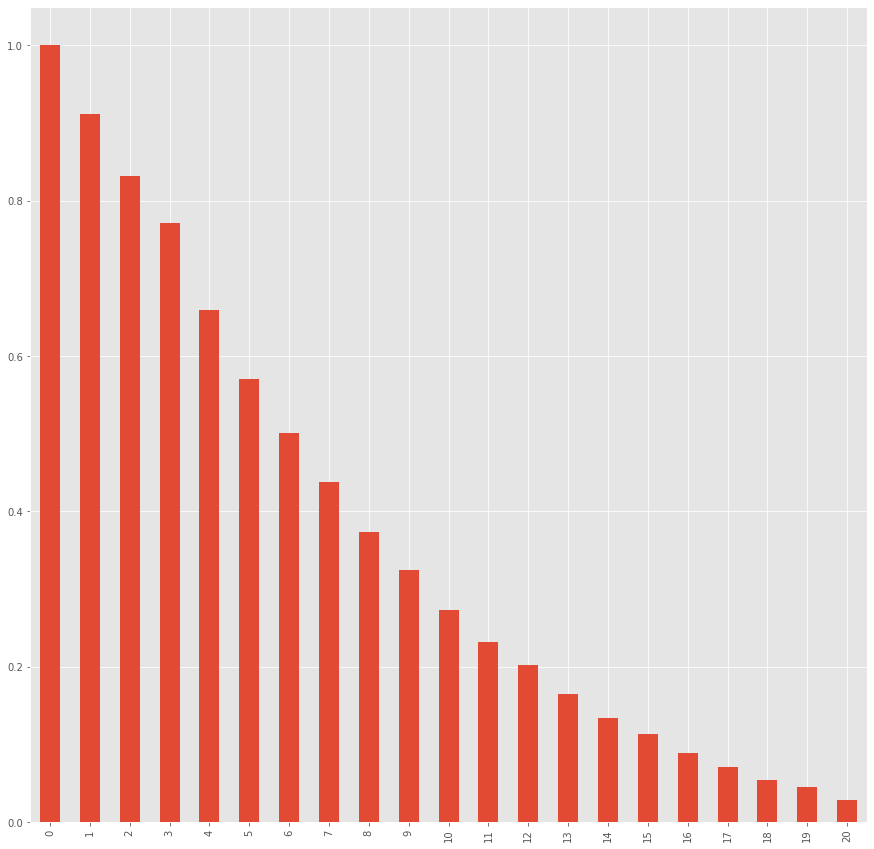

In [0]:
lag_acf = acf(tmp_df['lag'], nlags=20)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

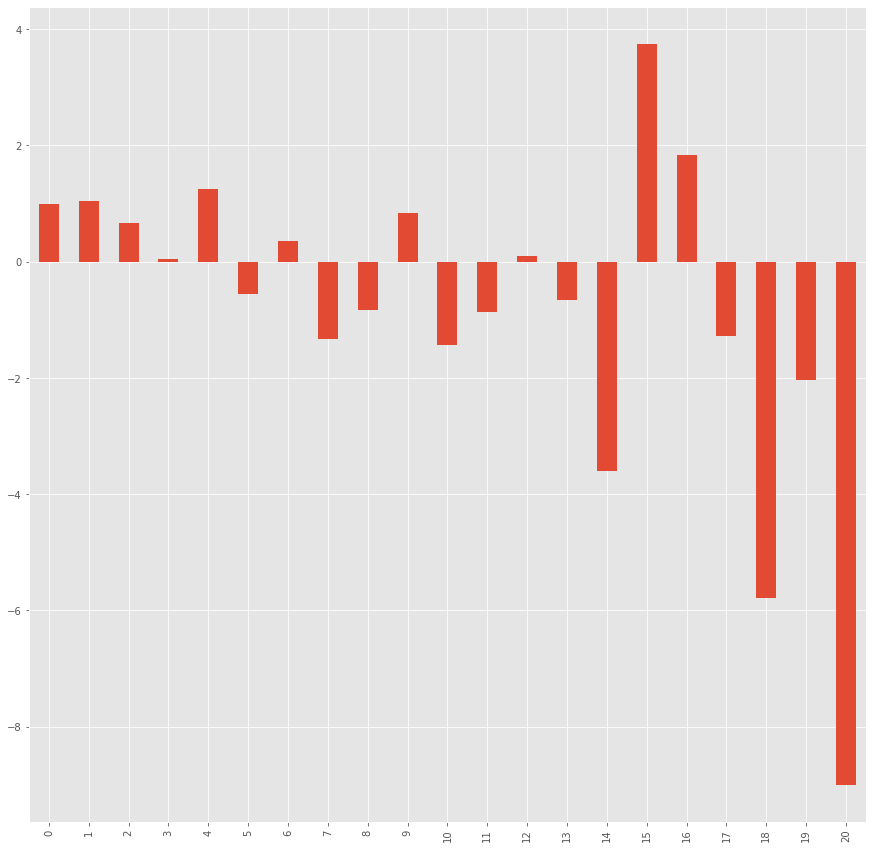

In [0]:
lag_pacf = pacf(tmp_df['lag'], nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

Графики построенны для прироста числа зараженных в России.

По графику автокорреляционной функции (ACF) можно определить порядок MA компоненты в ARMA модели. Количество компонентов, сильно отличных от нуля - 2-3.

По графику чистично автокорреляционной функции (PACF) можно определить порядок AR компоненты - 1.

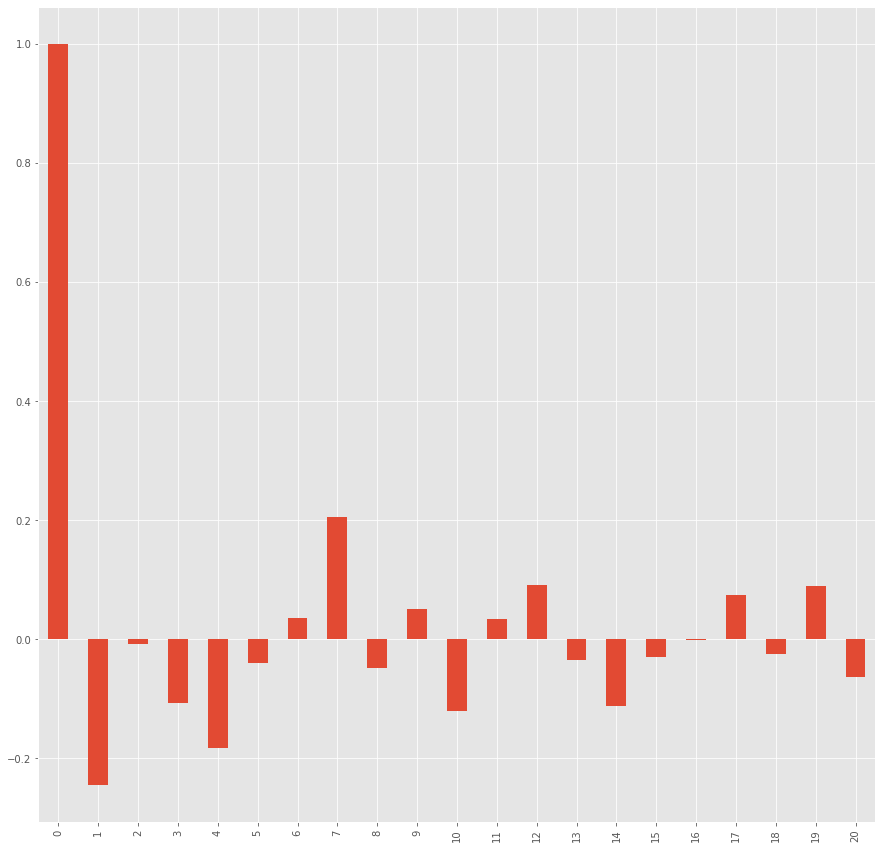

In [0]:
lag_acf = acf((tmp_df['lag']- seasonal_decompose(tmp_df['lag'], model='additive').trend)[3:-3], nlags=20)
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

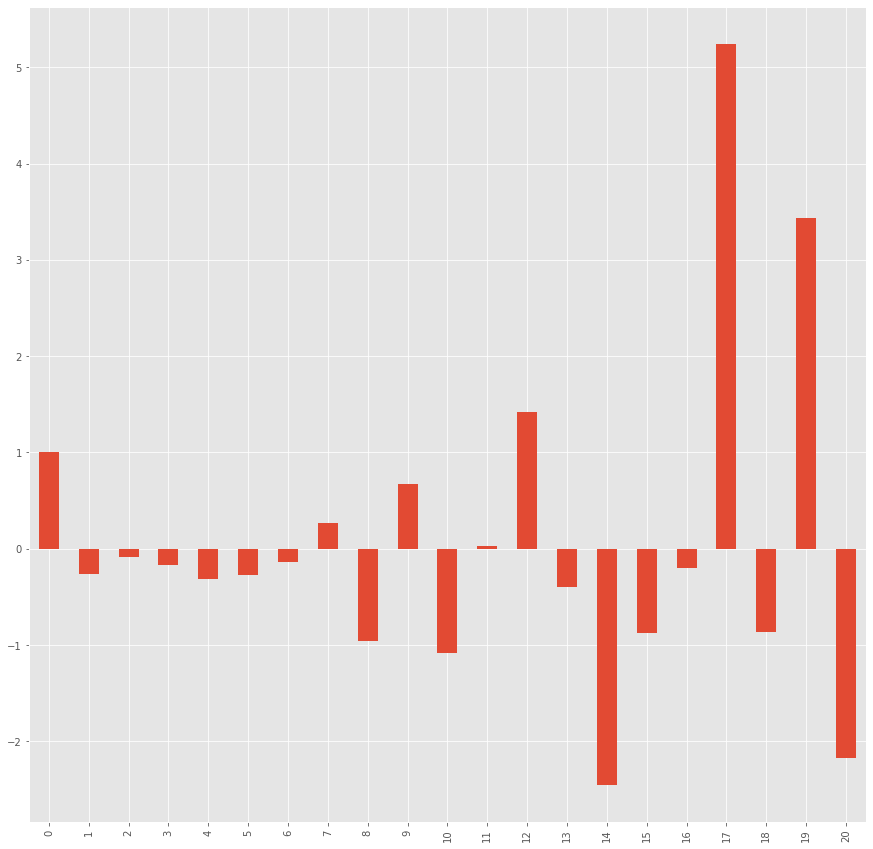

In [0]:
lag_pacf = pacf((tmp_df['lag']- seasonal_decompose(tmp_df['lag'], model='additive').trend)[3:-3], nlags=20, method='ols')
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

Если расчитывать для ряда без тренда.

Порядок MA компоненты в ARMA модели - 1.

Порядок AR компоненты - 1.

#### 1.10. Изучаемый Вами датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавьте новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. Сохраните полученный датасет, вы можете его использовать во второй части домашнего задания.
- Исследуйте как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. Сделайте выводы.

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. Вы можете использовать любой найденный датасет. Главное, чтобы у Вас получилось скомбинировать данные.*

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [0]:
dm = dt.datetime.strptime(df['Date'].max(), '%Y-%m-%d')
tt = lambda x: (dm - dt.datetime.strptime(x, '%Y-%m-%d')).days
df_days = df[df['Confirmed'] != 0][['Date', 'Country/Region']].groupby(['Country/Region']).min().reset_index()
df_days['Date'] = df_days['Date'].apply(tt)
features = df_days.set_index('Country/Region')

In [0]:
!wget https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-life-expectancy.json -q -O life_exp.json

In [0]:
lex = pd.read_json('life_exp.json')
lex.replace({'Russian Federation': 'Russia', 'Czech Republic': 'Czechia', 'Congo': 'Congo (Brazzaville)',
                    'Fiji Islands': 'Fiji', 'Holy See (Vatican City State)': 'Holy See', 'South Korea': 'Korea, South',
                    'Libyan Arab Jamahiriya': 'Libya', 'SriLanka': 'Sri Lanka', 'United States': 'US'}, inplace=True)
features = features.join(lex.set_index('country'),  how='left').fillna(lex['expectancy'].mean())

In [0]:
!wget https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-population-density.json -q -O pop_dest.json

In [0]:
des = pd.read_json('pop_dest.json')
des.replace({'Russian Federation': 'Russia', 'Czech Republic': 'Czechia', 'Congo': 'Congo (Brazzaville)',
                    'Fiji Islands': 'Fiji', 'Holy See (Vatican City State)': 'Holy See', 'South Korea': 'Korea, South',
                    'Libyan Arab Jamahiriya': 'Libya', 'SriLanka': 'Sri Lanka', 'United States': 'US'}, inplace=True)
features = features.join(des.set_index('country'),  how='left').fillna(des['density'].mean())

In [0]:
!wget https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-religion.json -q -O religion.json

In [0]:
rel = pd.read_json('religion.json')
rel.replace({'Russian Federation': 'Russia', 'Czech Republic': 'Czechia', 'Congo': 'Congo (Brazzaville)',
                    'Fiji Islands': 'Fiji', 'Holy See (Vatican City State)': 'Holy See', 'South Korea': 'Korea, South',
                    'Libyan Arab Jamahiriya': 'Libya', 'SriLanka': 'Sri Lanka', 'United States': 'US'}, inplace=True)
features = features.join(rel.set_index('country'),  how='left').fillna('__null__')

In [0]:
!wget https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-landlocked.json -q -O locked.json

In [0]:
ll = pd.read_json('locked.json')
ll.replace({'Russian Federation': 'Russia', 'Czech Republic': 'Czechia', 'Congo': 'Congo (Brazzaville)',
                    'Fiji Islands': 'Fiji', 'Holy See (Vatican City State)': 'Holy See', 'South Korea': 'Korea, South',
                    'Libyan Arab Jamahiriya': 'Libya', 'SriLanka': 'Sri Lanka', 'United States': 'US'}, inplace=True)
ll.replace({'': 0}, inplace=True)
features = features.join(ll.set_index('country'),  how='left').fillna(2)
features['landlocked'] = features['landlocked'].astype(np.uint8)

In [0]:
!wget https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-population.json -q -O population.json

In [0]:
pop = pd.read_json('population.json')
pop.replace({'Russian Federation': 'Russia', 'Czech Republic': 'Czechia', 'Congo': 'Congo (Brazzaville)',
                    'Fiji Islands': 'Fiji', 'Holy See (Vatican City State)': 'Holy See', 'South Korea': 'Korea, South',
                    'Libyan Arab Jamahiriya': 'Libya', 'SriLanka': 'Sri Lanka', 'United States': 'US'}, inplace=True)
features = features.join(pop.set_index('country'),  how='left').fillna(pop['population'].mean())

In [0]:
!wget https://raw.githubusercontent.com/samayo/country-json/master/src/country-by-continent.json -q -O continent.json

In [0]:
con = pd.read_json('continent.json')
con.replace({'Russian Federation': 'Russia', 'Czech Republic': 'Czechia', 'Congo': 'Congo (Brazzaville)',
                    'Fiji Islands': 'Fiji', 'Holy See (Vatican City State)': 'Holy See', 'South Korea': 'Korea, South',
                    'Libyan Arab Jamahiriya': 'Libya', 'SriLanka': 'Sri Lanka', 'United States': 'US'}, inplace=True)
features = features.join(con.set_index('country'),  how='left').fillna('__null__')

In [0]:
features.head()

Date  expectancy  ...      population continent
Country/Region                    ...                          
Afghanistan       68   45.900000  ... 35530081.000000      Asia
Albania           54   71.600000  ...  2930187.000000    Europe
Algeria           67   69.700000  ... 41318142.000000    Africa
Andorra           61   83.500000  ...    76965.000000    Europe
Angola            43   38.300000  ... 29784193.000000    Africa

[5 rows x 7 columns]

In [0]:
df12 = df11.join(features, on='Country/Region', how='left', rsuffix='_')
df12.head()

Date Country/Region  ...  population  continent
Date                                  ...                       
2020-01-22 2020-01-22    Afghanistan  ... 35530081.00       Asia
2020-01-22 2020-01-22        Albania  ...  2930187.00     Europe
2020-01-22 2020-01-22        Algeria  ... 41318142.00     Africa
2020-01-22 2020-01-22        Andorra  ...    76965.00     Europe
2020-01-22 2020-01-22         Angola  ... 29784193.00     Africa

[5 rows x 11 columns]

In [0]:
cont0 = features.sort_values(by='Date', ascending=False)[:5]
cont0 = cont0.append(features.sort_values(by='Date')[:5])
cont0.index

Index(['Canada', 'Japan', 'US', 'Thailand', 'Taiwan*', 'Yemen',
       'Sao Tome and Principe', 'Western Sahara', 'South Sudan', 'Malawi'],
      dtype='object', name='Country/Region')

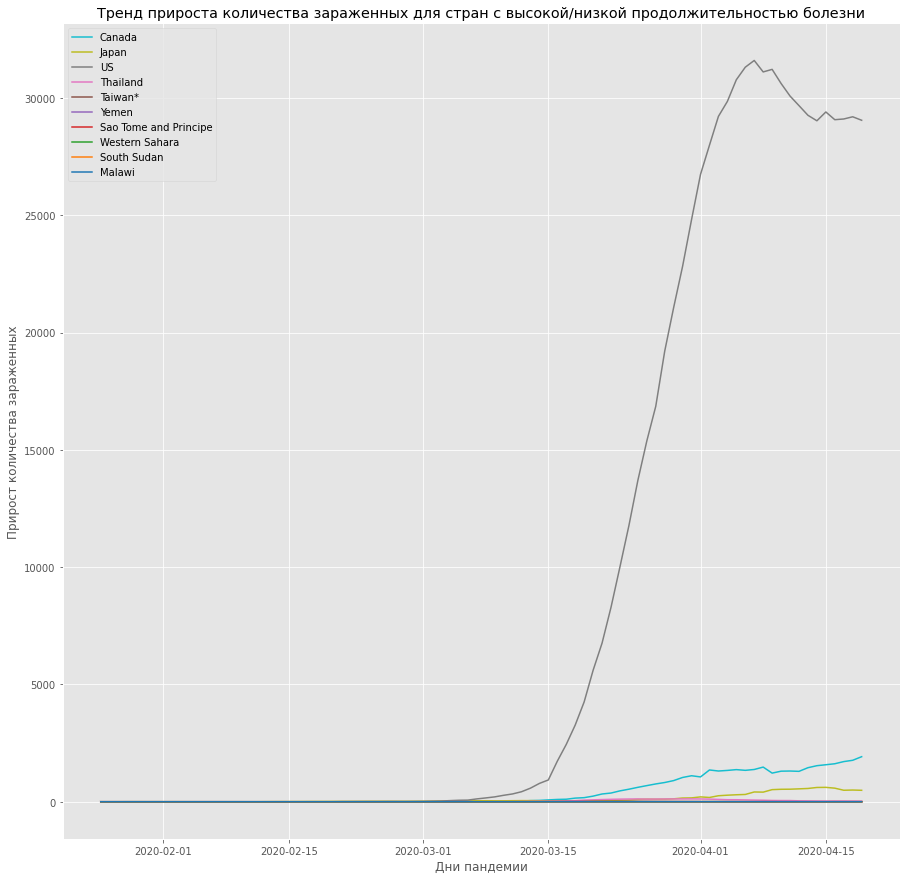

In [0]:
colors = list(plt.cm.tab10(np.arange(10)))
for con in cont0.index:
    tmp_df = df11[df11['Country/Region'] == con]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=con, color=colors.pop())

plt.legend()
plt.title('Тренд прироста количества зараженных для стран с высокой/низкой продолжительностью болезни')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Дни пандемии')
plt.show()

In [0]:
cont1 = features.sort_values(by='expectancy', ascending=False)[:5]
cont1 = cont1.append(features.sort_values(by='expectancy')[:5])
cont1.index

Index(['Andorra', 'San Marino', 'Japan', 'Singapore', 'Australia', 'Zambia',
       'Mozambique', 'Malawi', 'Zimbabwe', 'Angola'],
      dtype='object', name='Country/Region')

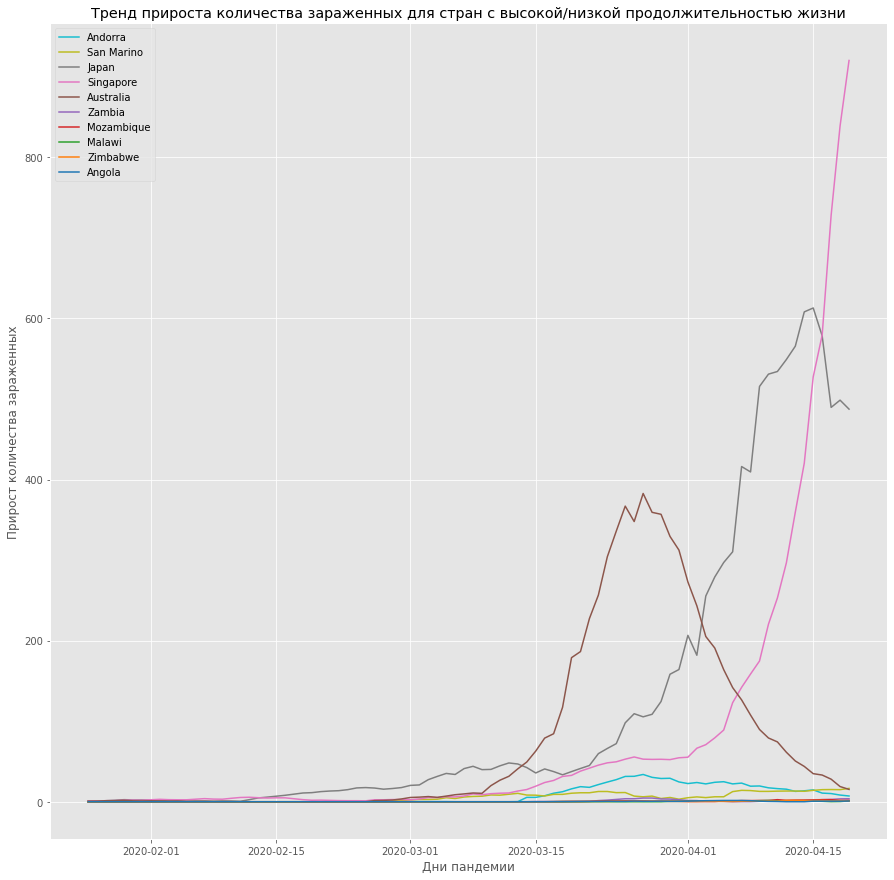

In [0]:
colors = list(plt.cm.tab10(np.arange(10)))
for con in cont1.index:
    tmp_df = df11[df11['Country/Region'] == con]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=con, color=colors.pop())

plt.legend()
plt.title('Тренд прироста количества зараженных для стран с высокой/низкой продолжительностью жизни')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Дни пандемии')
plt.show()

In [0]:
cont2 = features.sort_values(by='density', ascending=False)[:5]
cont2 = cont2.append(features.sort_values(by='density')[:5])
cont2.index

Index(['Barbados', 'Mauritius', 'San Marino', 'Netherlands', 'Rwanda',
       'South Sudan', 'Bangladesh', 'Maldives', 'Bahrain', 'Malta'],
      dtype='object', name='Country/Region')

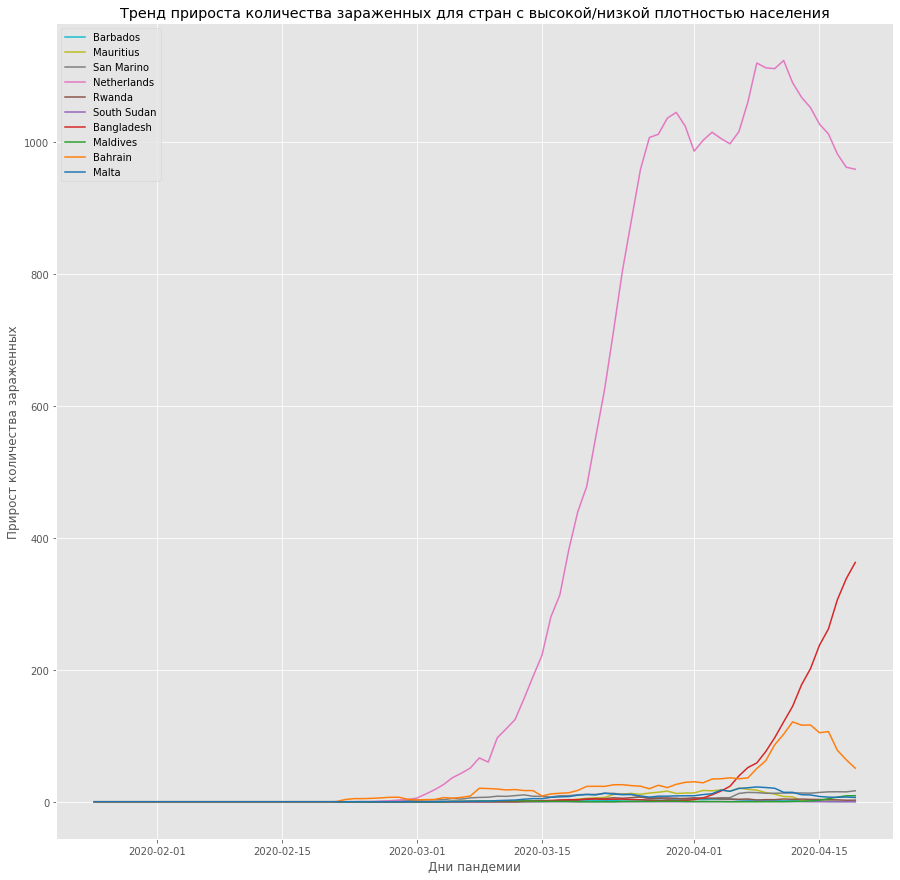

In [0]:
colors = list(plt.cm.tab10(np.arange(10)))
for con in cont2.index:
    tmp_df = df11[df11['Country/Region'] == con]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=con, color=colors.pop())

plt.legend()
plt.title('Тренд прироста количества зараженных для стран с высокой/низкой плотностью населения')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Дни пандемии')
plt.show()

In [0]:
df13 = df12[['lag', 'religion']].groupby(['Date', 'religion']).sum().reset_index()
df13.index = pd.PeriodIndex(df13['Date'], freq='D')
df13.index = df13.index.to_timestamp()

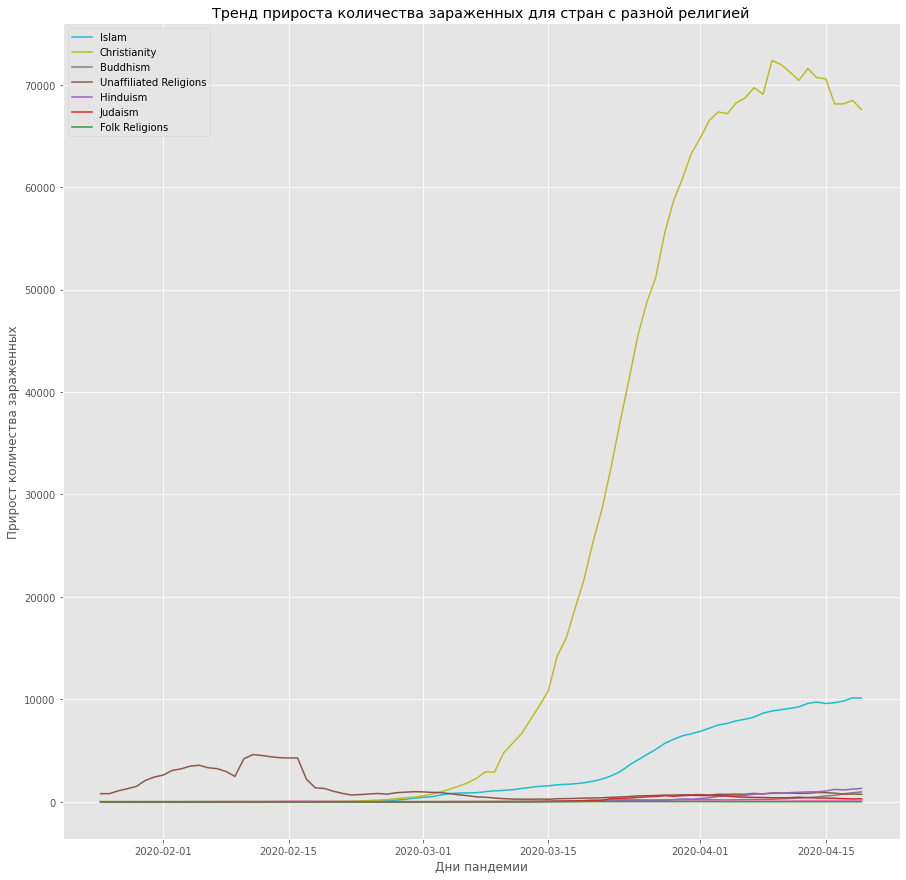

In [0]:
colors = list(plt.cm.tab10(np.arange(10)))
for rel in features['religion'].unique():
    tmp_df = df13[df13['religion'] == rel]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=rel, color=colors.pop())

plt.legend()
plt.title('Тренд прироста количества зараженных для стран с разной религией')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Дни пандемии')
plt.show()

In [0]:
df14 = df12[['lag', 'landlocked']].groupby(['Date', 'landlocked']).sum().reset_index()
df14.index = pd.PeriodIndex(df14['Date'], freq='D')
df14.index = df14.index.to_timestamp()

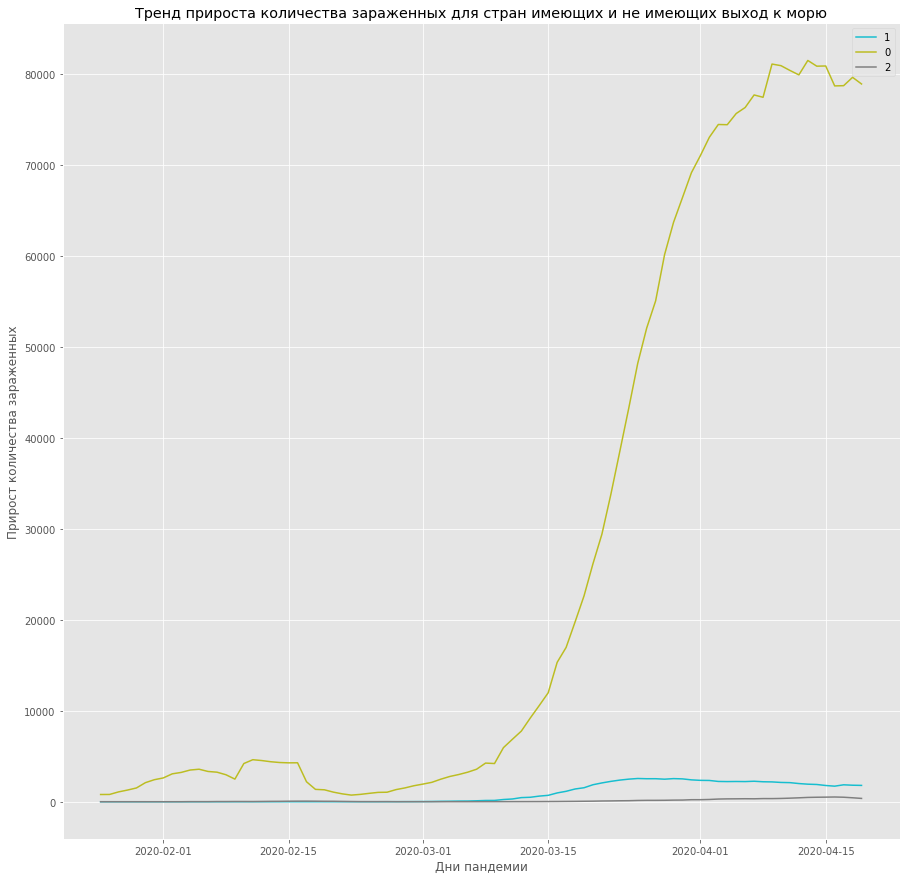

In [0]:
colors = list(plt.cm.tab10(np.arange(10)))
for rel in features['landlocked'].unique():
    tmp_df = df14[df14['landlocked'] == rel]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=rel, color=colors.pop())

plt.legend()
plt.title('Тренд прироста количества зараженных для стран имеющих и не имеющих выход к морю')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Дни пандемии')
plt.show()

In [0]:
df15 = df12[['lag', 'continent']].groupby(['Date', 'continent']).sum().reset_index()
df15.index = pd.PeriodIndex(df15['Date'], freq='D')
df15.index = df15.index.to_timestamp()

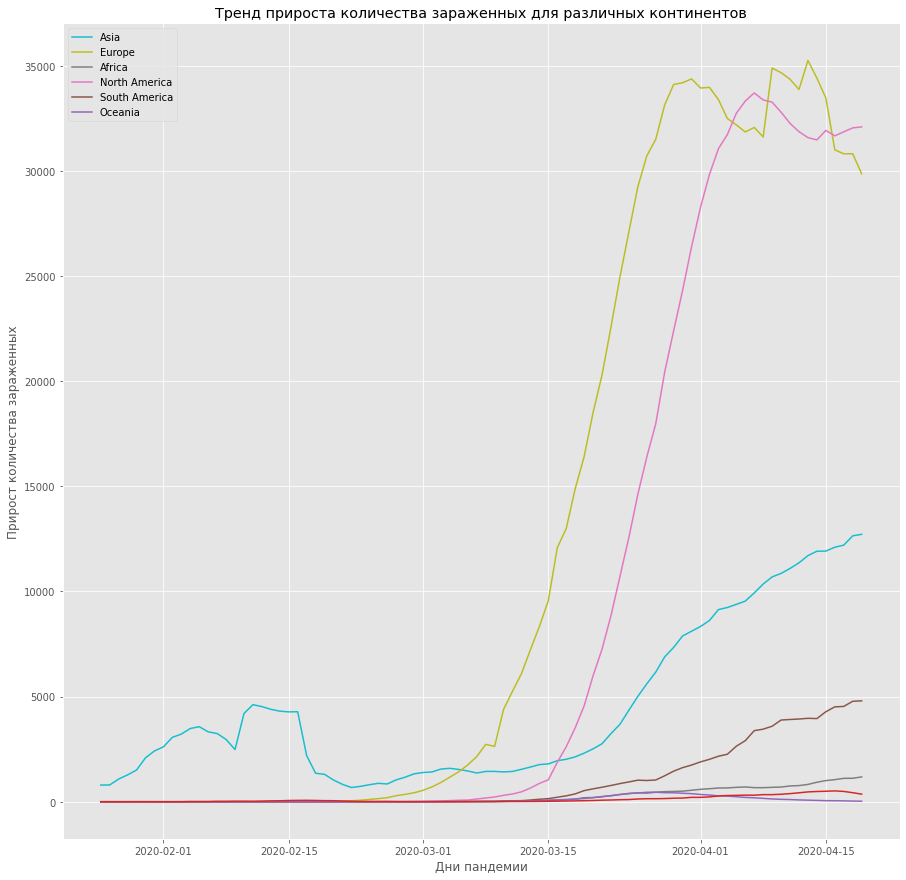

In [0]:
colors = list(plt.cm.tab10(np.arange(10)))
for rel in features['continent'].unique():
    tmp_df = df15[df15['continent'] == rel]
    plt.plot(seasonal_decompose(tmp_df['lag'], model='additive').trend, label=rel, color=colors.pop())

plt.legend()
plt.title('Тренд прироста количества зараженных для различных континентов')
plt.ylabel('Прирост количества зараженных')
plt.xlabel('Дни пандемии')
plt.show()

- Прирост заметен как раз в странах с самым большим количеством дней, а для стран, в которых прирост начался недавно - еще не заметен.

- Прирост заметен в странах с высокой продолжительностью жизни.

- Бангладеш и Бахрейн (страны с высокой плотностью населения) - у них заметен прирост. В Нидердландах небольшая плотность, но очень большой прирост. В остальных странах прирост практически незаметен. Странно, что от плотности населения распространение заразы явно не зависит.

- В странах с Хринстианством и Исламом очень сильно выявлен прирост. В странах с другими религиями (если не учитывать Китай), выраженного прироста нет.

- В странах, имеющих выход к морю больше всего прирост заболевших (стран с выходом к морю больше и транспортное сообщение между такими странами немного лучше).

- В Европе и Северной Америке больше всего прирост заболевших. 

### 1.11 Выводы
С помощью анализа датасета удалось выявить ряд географических и политических закономерностей. Эти закономерности хорошо известны образованному человеку и тому, что следит за новостями. Но однозначно, что машине это знать полезно. Например, что распространиение болезни началось с Китая. Сложная ситуация была в Италии, Испании и США. По графикам действительно видно, в каких странах начали болеть раньше.

Были добавлены дополнительные данные, которые могут помочь в определении сложных зависимостей: количество дней с начала болезни, продолжительность жизни, плотность населения, религия стран, какие страны имеют выход к морю, разделение стран по континентам.

## 2. Прогнозирование временного ряда

Теперь вам предстоит построить несколько моделей и спрогнозировать временной ряд для такого показателя как летальности от вируса. Летальность можно рассчитывать по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделайте несколько прогнозов для не менее 3 разных стран/регионов/другое (на ваш обоснованный выбор). Главное, чтобы каждый из типов моделей прознозировал одинаковый набор данных, чтобы в конце можно было сделать выводы о качестве работы той или иной модели.

Метрика качества RMSE. Не забудьте разбить данные временной ряд на данные для обучения и тестовые.

Не забывайте сопровождать ваш код комментариями, графиками и выводами.

In [0]:
d_rus = (df[(df['Country/Region'] == 'Russia') & (df['Deaths'] != 0)]['Date']).min()
rus_series = df[(df['Country/Region'] == 'Russia') & (df['Date'] >= d_rus)][['Date', 'Confirmed', 'Deaths']].groupby(['Date']).sum().reset_index()
rus_series['cfr'] = rus_series['Deaths'] / rus_series['Confirmed']
# rus_series['lag'] = rus_series['cfr'] - rus_series.shift(periods=1, fill_value=0)['cfr']

In [0]:
d_us = (df[(df['Country/Region'] == 'US') & (df['Deaths'] != 0)]['Date']).min()
us_series = df[(df['Country/Region'] == 'US') & (df['Date'] >= d_us)][['Date', 'Confirmed', 'Deaths']].groupby(['Date']).sum().reset_index()
us_series['cfr'] = us_series['Deaths'] / us_series['Confirmed']
# us_series['lag'] = us_series['cfr'] - us_series.shift(periods=1, fill_value=0)['cfr']

In [0]:
eur_series = df.join(features, on='Country/Region', how='left', rsuffix='_')
d_eur = (eur_series[(eur_series['continent'] == 'Europe') & (eur_series['Deaths'] != 0)]['Date']).min()
eur_series = eur_series[(eur_series['continent'] == 'Europe') & (eur_series['Date'] >= d_eur)][['Date', 'Confirmed', 'Deaths']].groupby(['Date']).sum().reset_index()
eur_series['cfr'] = eur_series['Deaths'] / eur_series['Confirmed']
# eur_series['lag'] = eur_series['cfr'] - eur_series.shift(periods=1, fill_value=0)['cfr']

### 2.1 Прогнозирование средним (Mean Constant Model)

Будем сравнивать ситуации в России, США и Европе (тренд в Европе задают Италия и Испания). В России ситуация для нас интереснее всего. В США и Европе ситуация все еще развивается стремительно (в отличие от Китая, который уже пережил пик пандемии), поэтому нам она тоже интересна.

Возмьем данные за последние 2 недели в качестве тестовых данных. Данные отфильтруем так, чтобы учитывать время только с момента первого умершего в регионе. 

In [0]:
view = {
    'Russia': {'series': rus_series},
    'US': {'series': us_series},
    'Europe': {'series': eur_series},
}

In [0]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

In [0]:
l = max(len(v['series']) for k,v in view.items())

In [0]:
for k, v in view.items():
    v['series']['Date'] = pd.to_datetime(v['series']['Date'])
    v['series']['timeIndex'] = v['series']['Date'] - v['series']['Date'].min()
    v['series']['timeIndex'] = v['series']['timeIndex']/np.timedelta64(1, 'D')
    v['series']['timeIndex'] = v['series']['timeIndex'].round(0).astype(int)

In [0]:
split = view[list(view.keys())[0]]['series']['Date'].max() - dt.timedelta(days=14)
for k, v in view.items():
    v['train'] =  v['series'][v['series']['Date'] < split]
    v['test'] =  v['series'][v['series']['Date'] >= split]

    v['mean'] = v['train']['cfr'].mean()

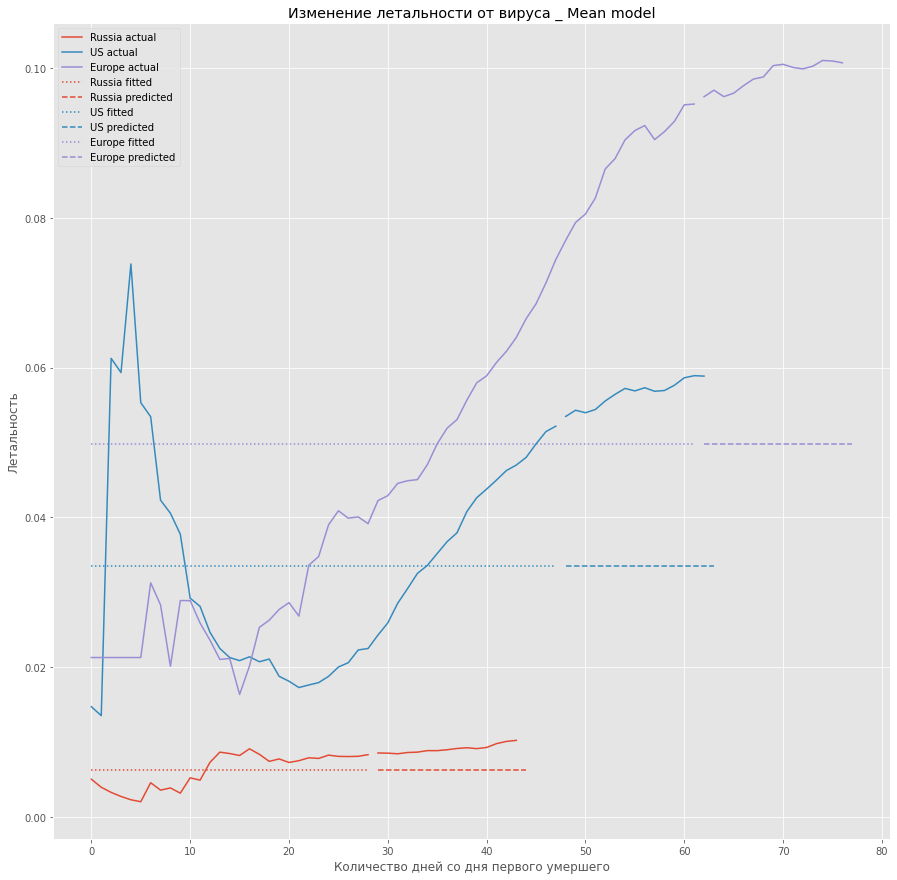

In [0]:
for k, v in view.items():
    color = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=color)
    plt.hlines(v['mean'], 0, len(v['train']['cfr']) - 1, linestyle=':', colors=color, label=f'{k} fitted')
    plt.hlines(v['mean'], len(v['train']['cfr']), len(v['train']['cfr']) + len(v['test']['cfr']), linestyle='--', colors=color, label=f'{k} predicted')
plt.legend()
plt.title('Изменение летальности от вируса _ Mean model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
results = pd.DataFrame(columns = ['Model'] + [f'{k} RMSE' for k,v in view.items()])
value_ =  {'Model': 'Mean Constant Model'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['mean'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0  Mean Constant Model     0.002890 0.023060     0.049160

#### 2.2 Линейная модель (Linear Trend Model) 

Для построения предсказания с помощью линейной модели возьмем bias и коэффициент наклона, а затем построим соответствующие прямые.



In [0]:
for k, v in view.items():
    linear_model = smfa.ols('cfr ~ timeIndex', data = v['train']).fit()
    a, b = linear_model.params
    l_tr, l_ts = len(v['train']), len(v['test'])
    v['linear'] = {'train' : b * np.linspace(0, l_tr, l_tr) + a,
                   'test' : b * np.linspace(l_tr, l_tr + l_ts, l_ts) + a}

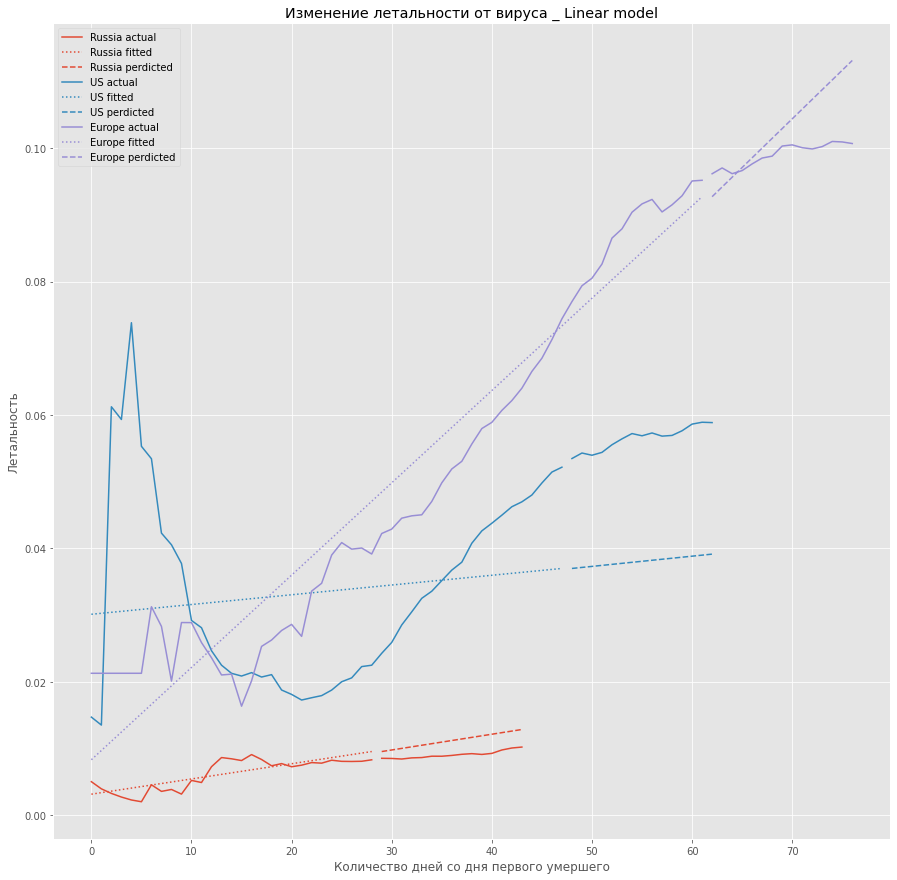

In [0]:
for k, v in view.items():
    color = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['linear']['train'], c=color, linestyle=':', label=f'{k} fitted')
    plt.plot(v['test']['cfr'], color=color)
    plt.plot(range(len(v['train']['cfr']), len(v['train']['cfr']) + len(v['test']['cfr'])), v['linear']['test'], c=color, linestyle='--', label=f'{k} perdicted')

plt.legend()
plt.title('Изменение летальности от вируса _ Linear model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'Linear Trend Model'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['linear']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0  Mean Constant Model     0.002890 0.023060     0.049160
1   Linear Trend Model     0.002188 0.018451     0.006165

#### 2.3 Экспоненциальное сглаживание (Exponential smoothing)

Попробуйте так же применить Double exponential smoothing или Triple exponential smoothing.

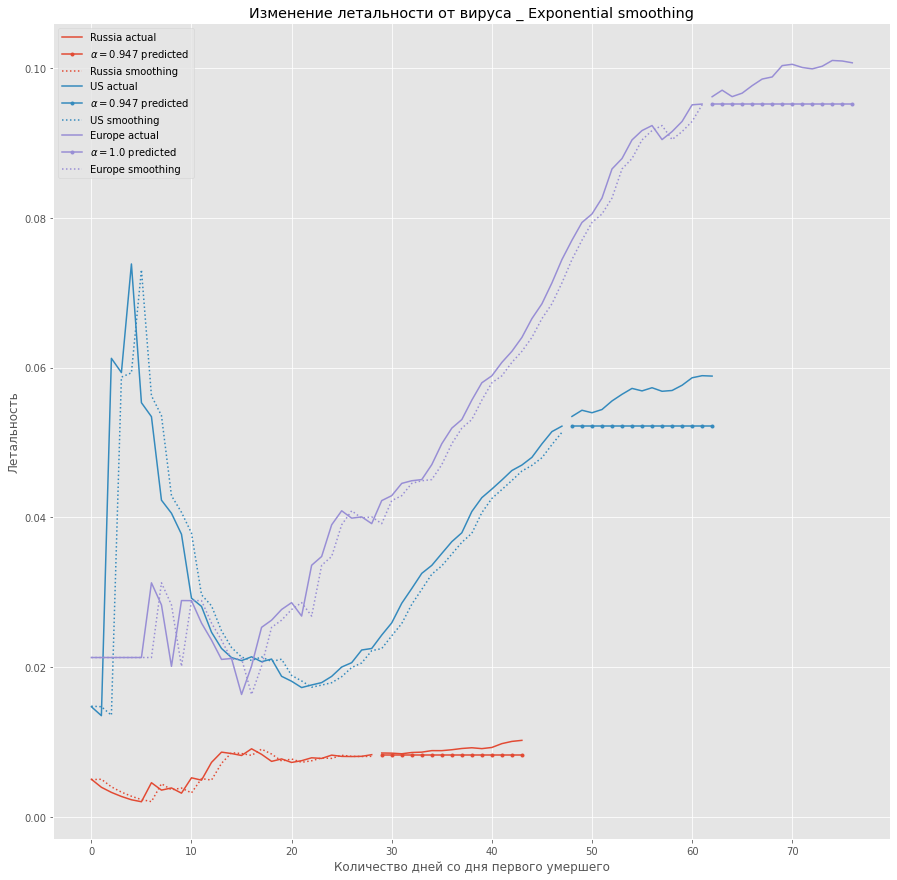

In [0]:
for k, v in view.items():
    fit = SimpleExpSmoothing(v['train']['cfr']).fit()
    fcast = fit.forecast(15).rename(r'$\alpha=%.5s$ predicted'%fit.model.params['smoothing_level'])
    v['simple_exp'] = {'train' : fit,
                       'test' : fcast}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    fcast.plot(marker='.', color=c, legend=True)
    fit.fittedvalues.plot(linestyle=':', color=c, label=f'{k} smoothing')

plt.legend()
plt.title('Изменение летальности от вируса _ Exponential smoothing')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'Exponential smoothing'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['simple_exp']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0    Mean Constant Model     0.002890 0.023060     0.049160
1     Linear Trend Model     0.002188 0.018451     0.006165
2  Exponential smoothing     0.000844 0.004504     0.004059

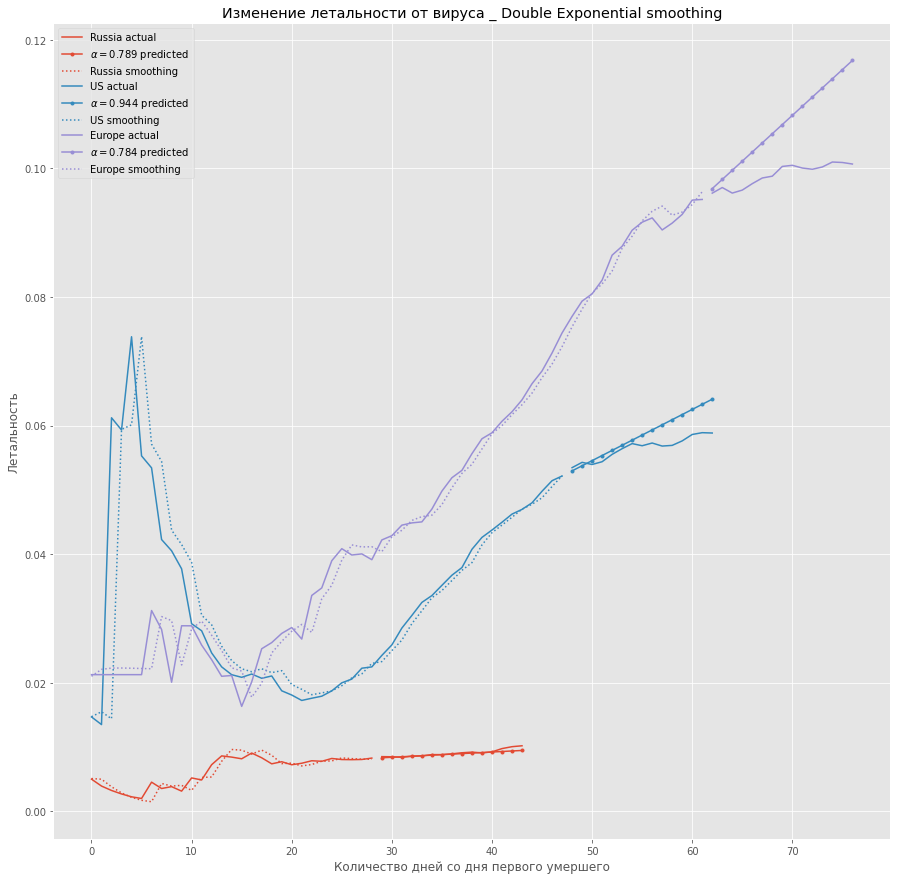

In [0]:
for k, v in view.items():
    fit = Holt(v['train']['cfr']).fit()
    fcast = fit.forecast(15).rename(r'$\alpha=%.5s$ predicted'%fit.model.params['smoothing_level'])
    v['double_exp'] = {'train' : fit,
                       'test' : fcast}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    fcast.plot(marker='.', color=c, legend=True)
    fit.fittedvalues.plot(linestyle=':', color=c, label=f'{k} smoothing')

plt.legend()
plt.title('Изменение летальности от вируса _ Double Exponential smoothing')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'Double Exponential smoothing'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['double_exp']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0           Mean Constant Model     0.002890 0.023060     0.049160
1            Linear Trend Model     0.002188 0.018451     0.006165
2         Exponential smoothing     0.000844 0.004504     0.004059
3  Double Exponential smoothing     0.000231 0.002507     0.008371

#### 2.4 Скользящее среднее (MA - Moving average)

Поэксперементируйте с гиперпараметрами модели.

Далее будем рассматривать прирост изменения CFR. Ряд для США оказался стационарным.

После получения с помощью какой-либо модели прогноза прироста летальности. Будем получать прогноз для самой летальности, прибавив к перому элементу прогноза прироста значение летальности за день до прогноза, а потом посчитав кумулятивную сумму.

Ряд для Russia не стационарен
Ряд для US стационарен
Ряд для Europe не стационарен


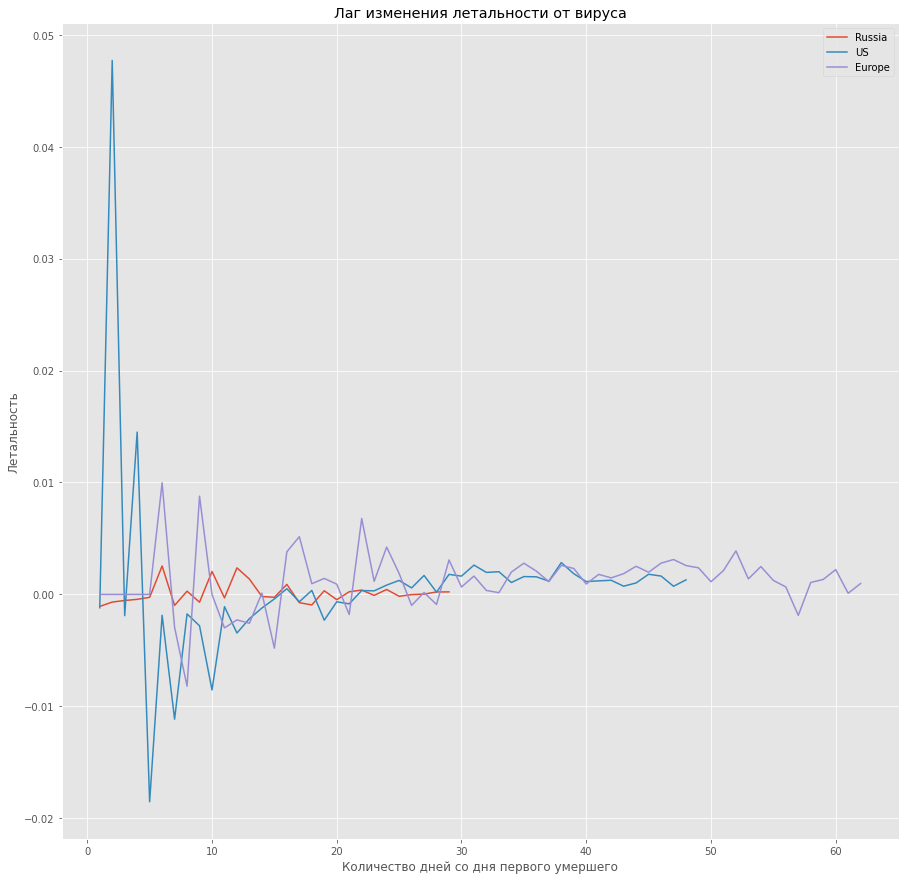

In [0]:
for k, v in view.items():
    v['train']['lag_cfr'] = (v['train']['cfr'] - v['train']['cfr'].shift())
    v['test']['lag_cfr'] = (v['test']['cfr'] - v['test']['cfr'].shift())
    plt.plot(v['train']['lag_cfr'], label=k)
    test = sma.tsa.adfuller(v['train']['lag_cfr'][1:])
    if test[0]> test[4]['5%']: 
        print(f'Ряд для {k} не стационарен')
    else:
        print(f'Ряд для {k} стационарен')

plt.legend()
plt.title('Лаг изменения летальности от вируса')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

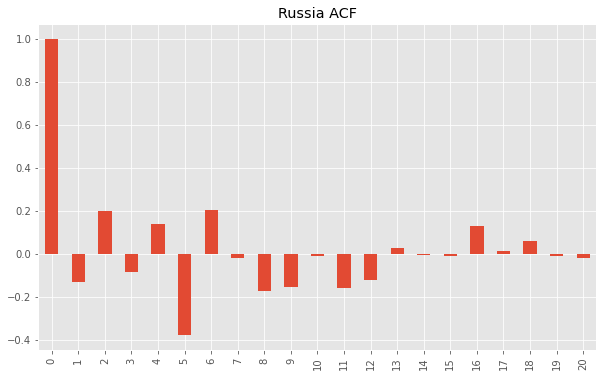

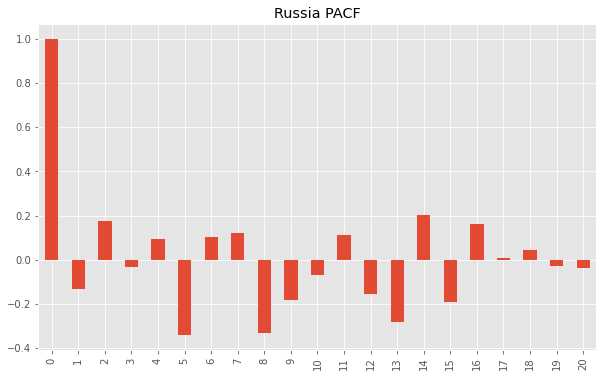

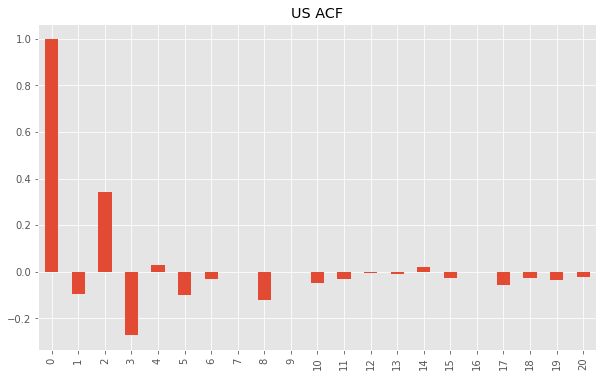

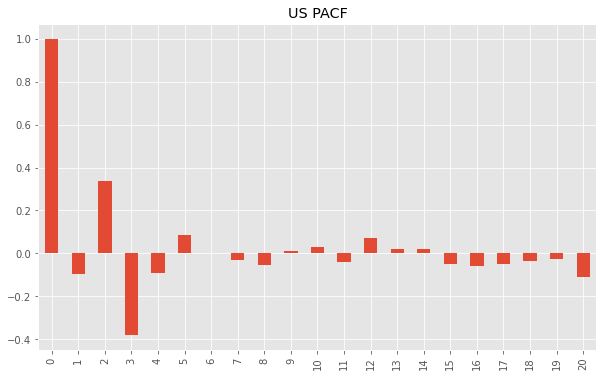

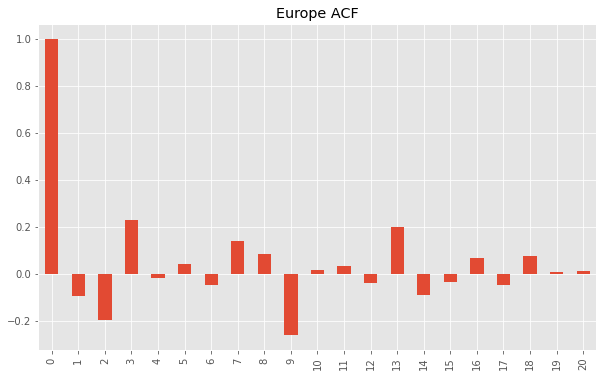

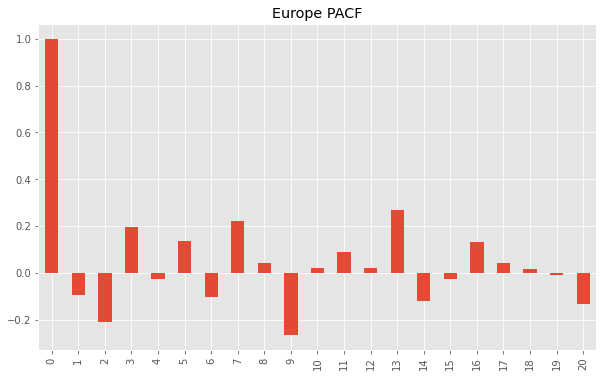

In [0]:
for k, v in view.items():
    lag_acf = acf(v['train']['lag_cfr'][1:], nlags=20)
    ACF = pd.Series(lag_acf)
    ACF.plot(kind = "bar", figsize=(10, 6), title=f'{k} ACF');
    plt.show()

    lag_pacf = pacf(v['train']['lag_cfr'][1:], nlags=20, method='ols')
    PACF = pd.Series(lag_pacf)
    PACF.plot(kind = "bar", figsize=(10, 6), title=f'{k} PACF');
    plt.show()

Для всех стран оптимальный коэффициент AR и MA равен 1.

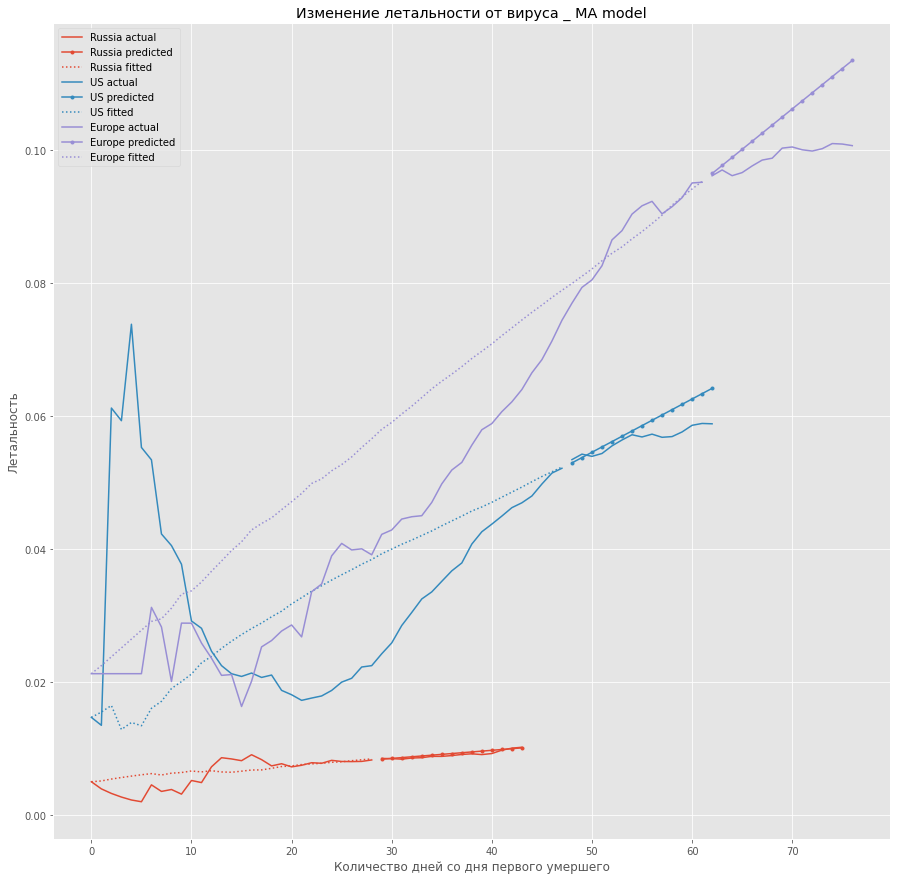

In [0]:
for k, v in view.items():
    model= ARIMA(v['train']['lag_cfr'][1:], order=(1,0,0), dates=v['train']['Date'][1:], freq='D')
    model_fit = model.fit(disp = -1)
    fcast = model_fit.forecast(15)[0]
    fcast[0] += v['train']['cfr'][len(v['train']['cfr'])-1]
    ftrain = model_fit.fittedvalues.values
    ftrain = np.insert(ftrain, 0, v['train']['cfr'][0])
    v['ma_arima'] = {'train' : np.cumsum(ftrain),
                     'test' : np.cumsum(fcast)}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    plt.plot(range(len(v['ma_arima']['train']), len(v['ma_arima']['train']) + len(fcast)), v['ma_arima']['test'], marker='.', color=c, label=f'{k} predicted')
    plt.plot(v['ma_arima']['train'], linestyle=':', color=c, label=f'{k} fitted')

plt.legend()
plt.title('Изменение летальности от вируса _ MA model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'ARIMA(6, 0, 0)'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['ma_arima']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0           Mean Constant Model     0.002890 0.023060     0.049160
1            Linear Trend Model     0.002188 0.018451     0.006165
2         Exponential smoothing     0.000844 0.004504     0.004059
3  Double Exponential smoothing     0.000231 0.002507     0.008371
4                ARIMA(1, 0, 0)     0.000267 0.002820     0.007061
5                ARIMA(2, 0, 0)     0.000210 0.018660     0.007137
6                ARIMA(3, 0, 0)     0.000222 0.001862     0.007029
7                ARIMA(4, 0, 0)     0.000218 0.001899     0.007041
8                ARIMA(5, 0, 0)     0.000498 0.001997     0.006522
9                ARIMA(6, 0, 0)     0.000434 0.002497     0.006919

#### 2.5 Авторегрессионная модель (AR - Autoregressive model)

Поэксперементируйте с гиперпараметрами модели.

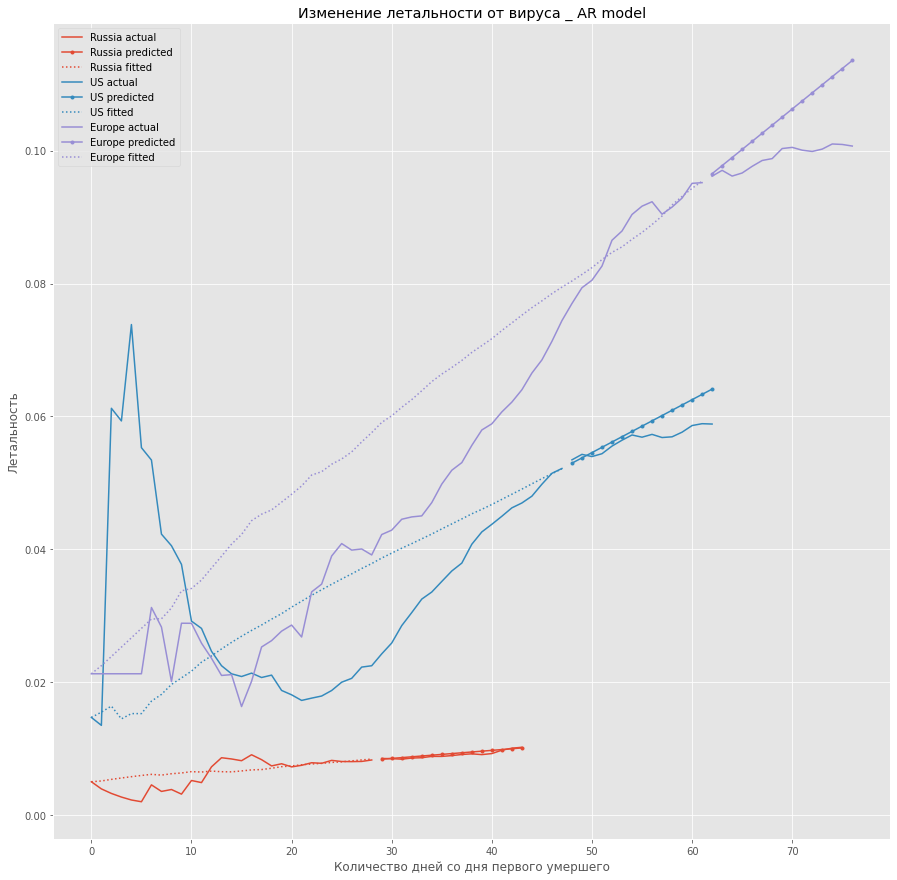

In [0]:
for k, v in view.items():
    model= ARIMA(v['train']['lag_cfr'][1:], order=(0,0,1), dates=v['train']['Date'][1:], freq='D')
    model_fit = model.fit(disp = -1)
    fcast = model_fit.forecast(15)[0]
    fcast[0] += v['train']['cfr'][len(v['train']['cfr'])-1]
    ftrain = model_fit.fittedvalues.values
    ftrain = np.insert(ftrain, 0, v['train']['cfr'][0])
    v['ar_arima'] = {'train' : np.cumsum(ftrain),
                     'test' : np.cumsum(fcast)}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    plt.plot(range(len(v['ar_arima']['train']), len(v['ar_arima']['train']) + len(fcast)), v['ar_arima']['test'], marker='.', color=c, label=f'{k} predicted')
    plt.plot(v['ar_arima']['train'], linestyle=':', color=c, label=f'{k} fitted')

plt.legend()
plt.title('Изменение летальности от вируса _ AR model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'ARIMA(0, 0, 4)'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['ar_arima']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0            Mean Constant Model     0.002890 0.023060     0.049160
1             Linear Trend Model     0.002188 0.018451     0.006165
2          Exponential smoothing     0.000844 0.004504     0.004059
3   Double Exponential smoothing     0.000231 0.002507     0.008371
4                 ARIMA(1, 0, 0)     0.000267 0.002820     0.007061
5                 ARIMA(2, 0, 0)     0.000210 0.018660     0.007137
6                 ARIMA(3, 0, 0)     0.000222 0.001862     0.007029
7                 ARIMA(4, 0, 0)     0.000218 0.001899     0.007041
8                 ARIMA(5, 0, 0)     0.000498 0.001997     0.006522
9                 ARIMA(6, 0, 0)     0.000434 0.002497     0.006919
10                ARIMA(0, 0, 1)     0.000266 0.002776     0.007113
11                ARIMA(0, 0, 2)     0.000215 0.004902     0.007098
12                ARIMA(0, 0, 3)     0.000208 0.005369     0.006689
13                ARIMA(0, 0, 4)     0.001595 0.004332     0.006753

#### 2.6 ARMA

Поэксперементируйте с гиперпараметрами модели.

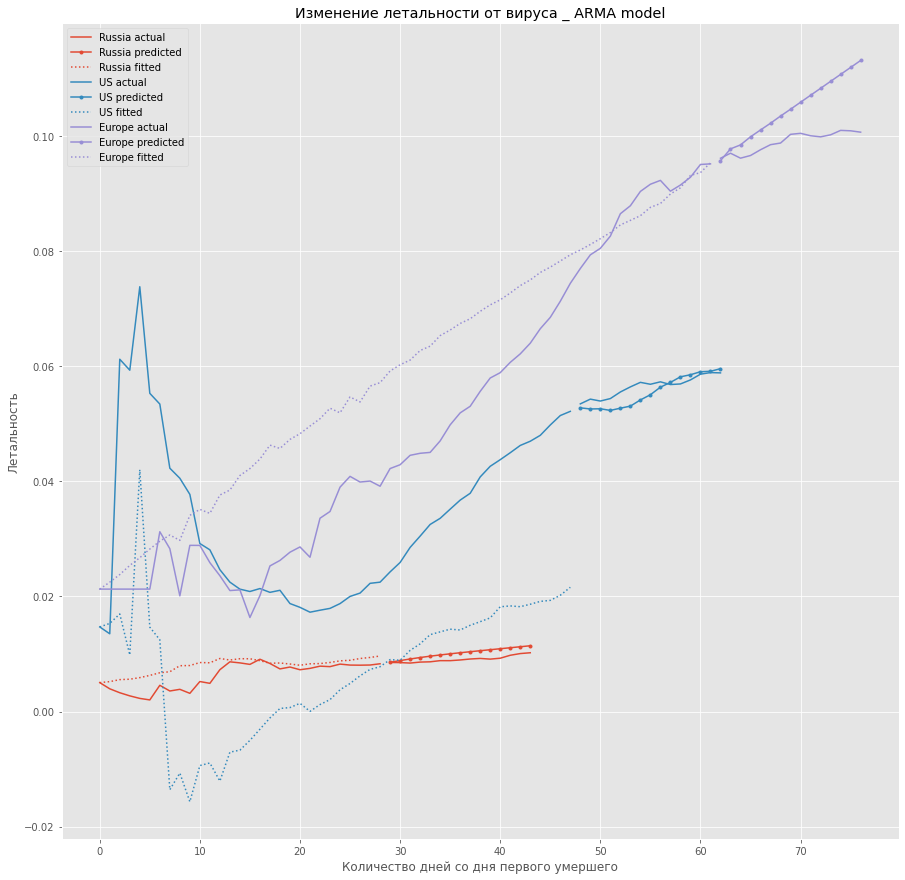

In [0]:
for k, v in view.items():
    model= ARIMA(v['train']['lag_cfr'][1:], order=(3,0,1), dates=v['train']['Date'][1:], freq='D')
    model_fit = model.fit(disp = -1)
    fcast = model_fit.forecast(15)[0]
    fcast[0] += v['train']['cfr'][len(v['train']['cfr'])-1]
    ftrain = model_fit.fittedvalues.values
    ftrain = np.insert(ftrain, 0, v['train']['cfr'][0])
    v['ar_ma_arima'] = {'train' : np.cumsum(ftrain),
                     'test' : np.cumsum(fcast)}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    plt.plot(range(len(v['ar_ma_arima']['train']), len(v['ar_ma_arima']['train']) + len(fcast)), v['ar_ma_arima']['test'], marker='.', color=c, label=f'{k} predicted')
    plt.plot(v['ar_ma_arima']['train'], linestyle=':', color=c, label=f'{k} fitted')

plt.legend()
plt.title('Изменение летальности от вируса _ ARMA model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'ARIMA(5, 0, 2)'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['ar_ma_arima']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0            Mean Constant Model     0.002890 0.023060     0.049160
1             Linear Trend Model     0.002188 0.018451     0.006165
2          Exponential smoothing     0.000844 0.004504     0.004059
3   Double Exponential smoothing     0.000231 0.002507     0.008371
4                 ARIMA(1, 0, 0)     0.000267 0.002820     0.007061
5                 ARIMA(2, 0, 0)     0.000210 0.018660     0.007137
6                 ARIMA(3, 0, 0)     0.000222 0.001862     0.007029
7                 ARIMA(4, 0, 0)     0.000218 0.001899     0.007041
8                 ARIMA(5, 0, 0)     0.000498 0.001997     0.006522
9                 ARIMA(6, 0, 0)     0.000434 0.002497     0.006919
10                ARIMA(0, 0, 1)     0.000266 0.002776     0.007113
11                ARIMA(0, 0, 2)     0.000215 0.004902     0.007098
12                ARIMA(0, 0, 3)     0.000208 0.005369     0.006689
13                ARIMA(0, 0, 4)     0.001595 0.004332     0.006753
14                ARIMA(3, 0, 1)     0.001142 0.001738     0.006787
15                ARIMA(4, 0, 1)     0.000223 0.002233     0.006772
16                ARIMA(4, 0, 2)     0.000220 0.001234          nan
17                ARIMA(5, 0, 2)     0.000518 0.002253     0.006896

#### 2.7 Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



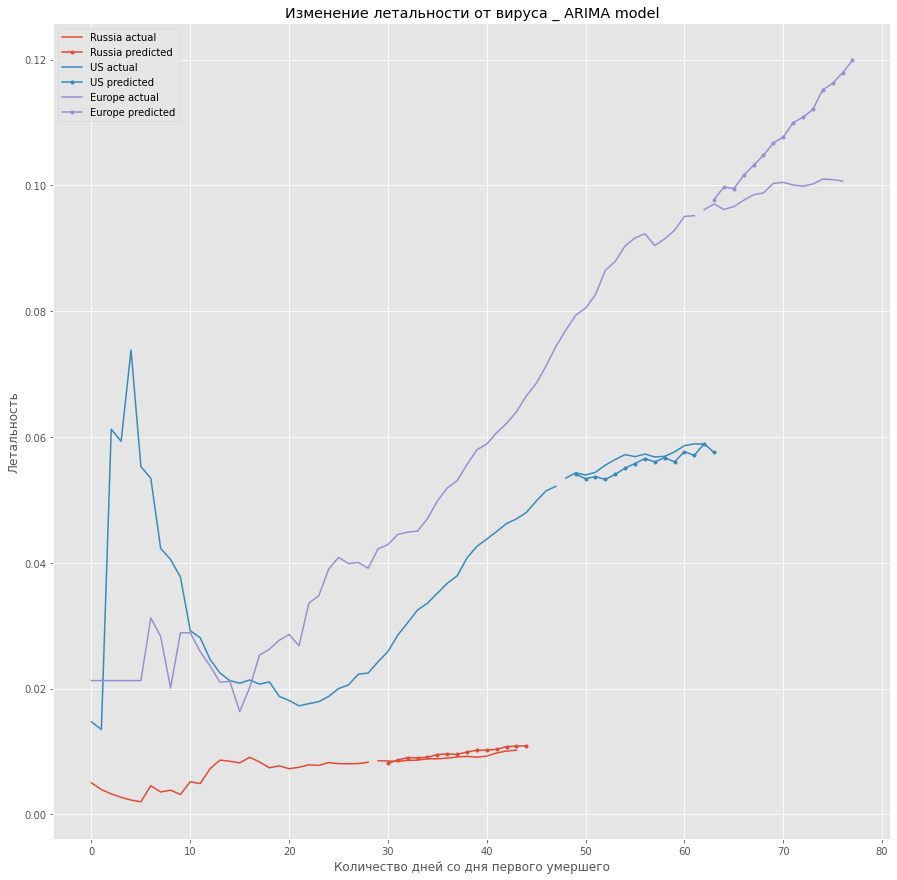

In [0]:
for k, v in view.items():
    model= ARIMA(v['train']['lag_cfr'][1:], order=(6,1,4), dates=v['train']['Date'][1:], freq='D')
    model_fit = model.fit(disp = -1)
    fcast = model_fit.forecast(15)[0]
    fcast[0] += v['train']['cfr'][len(v['train']['cfr'])-1]
    v['arima_arima'] = {'test' : np.cumsum(fcast)}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    plt.plot(range(len(v['train']['cfr']) + 1, len(v['train']['cfr']) + len(fcast) + 1), v['arima_arima']['test'], marker='.', color=c, label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ ARIMA model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'ARIMA(6, 1, 4)'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['arima_arima']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0            Mean Constant Model     0.002890 0.023060     0.049160
1             Linear Trend Model     0.002188 0.018451     0.006165
2          Exponential smoothing     0.000844 0.004504     0.004059
3   Double Exponential smoothing     0.000231 0.002507     0.008371
4                 ARIMA(1, 0, 0)     0.000267 0.002820     0.007061
5                 ARIMA(2, 0, 0)     0.000210 0.018660     0.007137
6                 ARIMA(3, 0, 0)     0.000222 0.001862     0.007029
7                 ARIMA(4, 0, 0)     0.000218 0.001899     0.007041
8                 ARIMA(5, 0, 0)     0.000498 0.001997     0.006522
9                 ARIMA(6, 0, 0)     0.000434 0.002497     0.006919
10                ARIMA(0, 0, 1)     0.000266 0.002776     0.007113
11                ARIMA(0, 0, 2)     0.000215 0.004902     0.007098
12                ARIMA(0, 0, 3)     0.000208 0.005369     0.006689
13                ARIMA(0, 0, 4)     0.001595 0.004332     0.006753
14                ARIMA(3, 0, 1)     0.001142 0.001738     0.006787
15                ARIMA(4, 0, 1)     0.000223 0.002233     0.006772
16                ARIMA(4, 0, 2)     0.000220 0.001234          nan
17                ARIMA(5, 0, 2)     0.000518 0.002253     0.006896
18                ARIMA(4, 1, 1)     0.002015 0.015494     0.016764
19                ARIMA(6, 1, 4)     0.000753 0.001005     0.010645

2.8 SARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



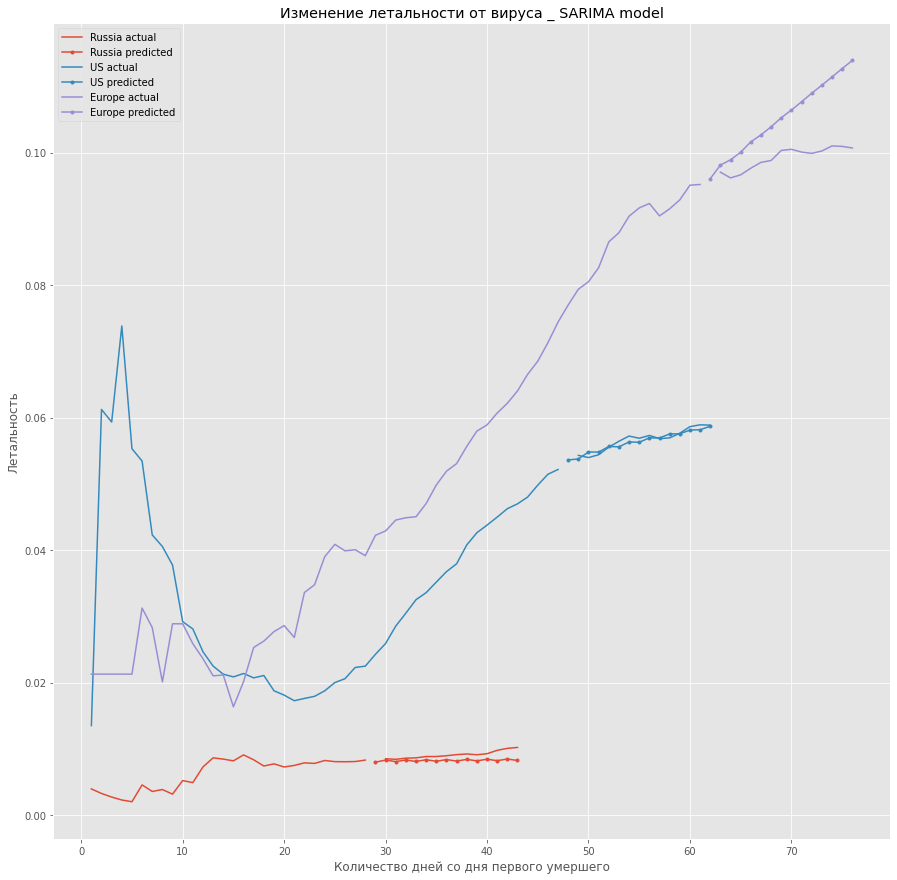

In [0]:
for k, v in view.items():
    model= sma.tsa.statespace.SARIMAX(v['train']['lag_cfr'][1:], order=(3,1,2), dates=v['train']['Date'][1:], freq='D')
    model_fit = model.fit(disp = -1)
    fcast = model_fit.get_prediction(len(v['train']['lag_cfr'][1:]), len(v['train']['lag_cfr'][1:])+14).conf_int().mean(axis=1).values
    fcast[0] += v['train']['cfr'][len(v['train']['cfr'])-1]
    v['sarima_arima'] = {'test' : np.cumsum(fcast)}
    c = plt.plot(v['train']['lag_cfr'][1:] + v['train']['cfr'].shift(), label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['lag_cfr'] + v['test']['cfr'].shift(), color=c)
    plt.plot(range(len(v['train']['cfr']), len(v['train']['cfr']) + len(fcast)), v['sarima_arima']['test'], marker='.', color=c, label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ SARIMA model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'SARIMA(3, 1, 2)'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['sarima_arima']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0            Mean Constant Model     0.002890 0.023060     0.049160
1             Linear Trend Model     0.002188 0.018451     0.006165
2          Exponential smoothing     0.000844 0.004504     0.004059
3   Double Exponential smoothing     0.000231 0.002507     0.008371
4                 ARIMA(1, 0, 0)     0.000267 0.002820     0.007061
5                 ARIMA(2, 0, 0)     0.000210 0.018660     0.007137
6                 ARIMA(3, 0, 0)     0.000222 0.001862     0.007029
7                 ARIMA(4, 0, 0)     0.000218 0.001899     0.007041
8                 ARIMA(5, 0, 0)     0.000498 0.001997     0.006522
9                 ARIMA(6, 0, 0)     0.000434 0.002497     0.006919
10                ARIMA(0, 0, 1)     0.000266 0.002776     0.007113
11                ARIMA(0, 0, 2)     0.000215 0.004902     0.007098
12                ARIMA(0, 0, 3)     0.000208 0.005369     0.006689
13                ARIMA(0, 0, 4)     0.001595 0.004332     0.006753
14                ARIMA(3, 0, 1)     0.001142 0.001738     0.006787
15                ARIMA(4, 0, 1)     0.000223 0.002233     0.006772
16                ARIMA(4, 0, 2)     0.000220 0.001234          nan
17                ARIMA(5, 0, 2)     0.000518 0.002253     0.006896
18                ARIMA(4, 1, 1)     0.002015 0.015494     0.016764
19                ARIMA(6, 1, 4)     0.000753 0.001005     0.010645
20               SARIMA(2, 0, 1)     0.000934 0.002169     0.004171
21               SARIMA(1, 0, 1)     0.000962 0.004658     0.004251
22               SARIMA(2, 0, 2)     0.000951 0.007176     0.001080
23               SARIMA(3, 0, 2)     0.000945 0.006382     0.000560
24               SARIMA(3, 1, 2)     0.000965 0.000542     0.007291

#### 2.9 Библиотека Prophet
Попробуйте использовать библиотеку Prophet для предсказания временного ряда. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


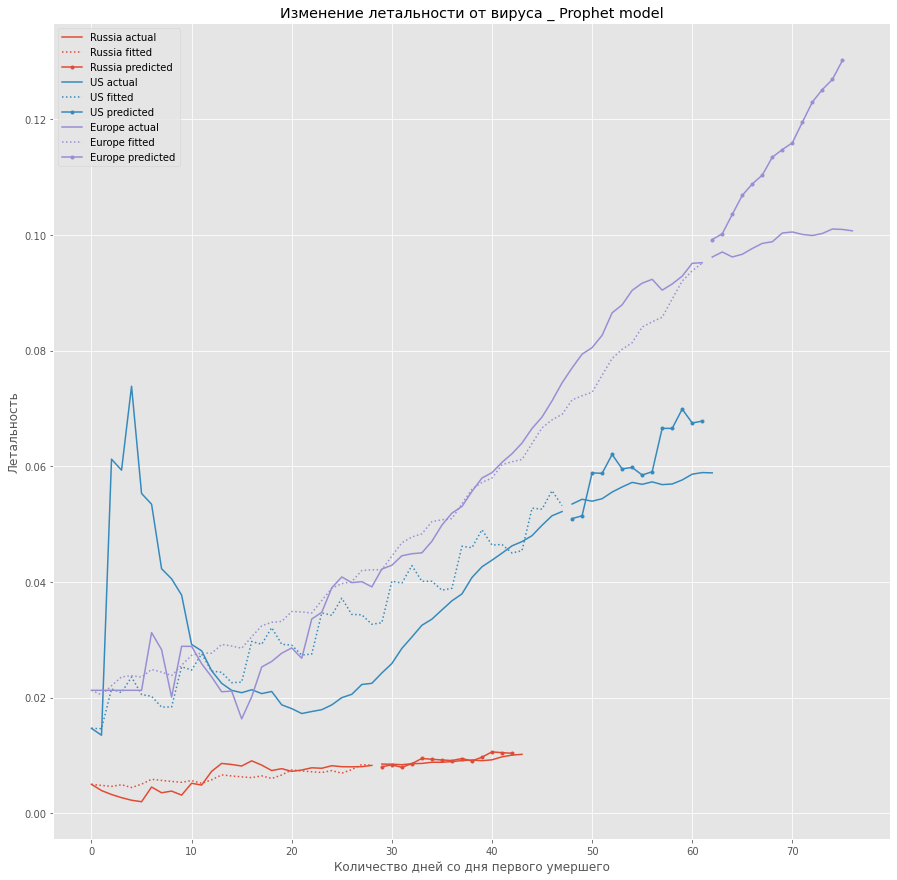

In [0]:
from fbprophet import Prophet

for k, v in view.items():
    prph = Prophet()
    df = v['train'][['Date', 'lag_cfr']][1:]
    df.columns = ['ds', 'y']
    prph.fit(df)
    future = prph.make_future_dataframe(periods=15)
    fcast = prph.predict(future)
    ftest = fcast['yhat'][-15:]
    ftrain = fcast['yhat'][:-15].values
    ftrain = np.insert(ftrain, 0, v['train']['cfr'][0])
    ftest[len(v['train']['cfr'])] += v['train']['cfr'][len(v['train']['cfr'])-1]
    v['prophet'] = {'train' : np.cumsum(ftrain),
                     'test' : np.cumsum(ftest)[1:]}
    c = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=c)
    plt.plot(v['prophet']['train'], linestyle=':', color=c, label=f'{k} fitted')
    plt.plot(v['prophet']['test'], marker='.', color=c, label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ Prophet model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()


In [0]:
value_ =  {'Model': 'Prophet'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['prophet']['test'], v['test']['cfr'])
results = results.append(value_, ignore_index=True)
results

Model  Russia RMSE  US RMSE  Europe RMSE
0            Mean Constant Model     0.002890 0.023060     0.049160
1             Linear Trend Model     0.002188 0.018451     0.006165
2          Exponential smoothing     0.000844 0.004504     0.004059
3   Double Exponential smoothing     0.000231 0.002507     0.008371
4                 ARIMA(1, 0, 0)     0.000267 0.002820     0.007061
5                 ARIMA(2, 0, 0)     0.000210 0.018660     0.007137
6                 ARIMA(3, 0, 0)     0.000222 0.001862     0.007029
7                 ARIMA(4, 0, 0)     0.000218 0.001899     0.007041
8                 ARIMA(5, 0, 0)     0.000498 0.001997     0.006522
9                 ARIMA(6, 0, 0)     0.000434 0.002497     0.006919
10                ARIMA(0, 0, 1)     0.000266 0.002776     0.007113
11                ARIMA(0, 0, 2)     0.000215 0.004902     0.007098
12                ARIMA(0, 0, 3)     0.000208 0.005369     0.006689
13                ARIMA(0, 0, 4)     0.001595 0.004332     0.006753
14                ARIMA(3, 0, 1)     0.001142 0.001738     0.006787
15                ARIMA(4, 0, 1)     0.000223 0.002233     0.006772
16                ARIMA(4, 0, 2)     0.000220 0.001234          nan
17                ARIMA(5, 0, 2)     0.000518 0.002253     0.006896
18                ARIMA(4, 1, 1)     0.002015 0.015494     0.016764
19                ARIMA(6, 1, 4)     0.000753 0.001005     0.010645
20               SARIMA(2, 0, 1)     0.000934 0.002169     0.004171
21               SARIMA(1, 0, 1)     0.000962 0.004658     0.004251
22               SARIMA(2, 0, 2)     0.000951 0.007176     0.001080
23               SARIMA(3, 0, 2)     0.000945 0.006382     0.000560
24               SARIMA(3, 1, 2)     0.000965 0.000542     0.007291
25                       Prophet     0.000577 0.006636     0.017209

#### 2.10 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?

Попробуем составить датафрейм с лагами (до 7 порядка, как дней в неделе), текущей датой и днем недели. Наиболее значимыми, как и ожидалось, оказались лаги.

In [0]:
from tqdm import tqdm_notebook

In [0]:
def df_to_lagdf(df, country, lags=7):
    result = []
    for i1, r1 in df.iterrows():
        newrow = {
            'country': country,
            'date': (r1['Date'] - view['Europe']['train']['Date'].min()).days,
            'target': r1['lag_cfr'],
            'weekday': r1['Date'].dayofweek
        }
        for i2, r2 in df.iterrows():
            if i1 - lags < i2 < i1:
                lag = i1 - i2
                # newrow[f'confirmed_{lag}'] = r2['Confirmed']
                # newrow[f'deaths_{lag}'] = r2['Deaths']
                # newrow[f'lag_cfr_{lag}'] = r2['lag_cfr']
                newrow[f'cfr_{lag}'] = r2['lag_cfr']
                newrow[f'date_{lag}'] = (r2['Date'] - df['Date'].min()).days
                newrow[f'weekday_{lag}'] = r2['Date'].dayofweek
        result.append(newrow)
    result = pd.DataFrame(result)
    return result[~result['target'].isna()].copy()

In [0]:
def lag_to_value(start, lags):
    lags = list(lags)
    lags[0] += start
    return np.cumsum(lags)

Russia Intercept    0.000000
date         0.000008
weekday      0.000191
cfr_1        0.034940
date_1      -0.000002
weekday_1   -0.000121
cfr_2        0.159374
date_2      -0.000003
weekday_2    0.000001
cfr_3        0.059560
date_3      -0.000003
weekday_3    0.000106
cfr_4       -0.001840
date_4      -0.000003
weekday_4   -0.000056
cfr_5       -0.275800
date_5      -0.000004
weekday_5    0.000050
cfr_6        0.247706
date_6      -0.000004
weekday_6   -0.000165
dtype: float64



US Intercept   -0.000002
date        -0.000024
weekday      0.000006
cfr_1        0.024917
date_1       0.000005
weekday_1    0.000160
cfr_2        0.572461
date_2       0.000007
weekday_2   -0.000122
cfr_3        0.022584
date_3       0.000009
weekday_3    0.000098
cfr_4       -0.069954
date_4       0.000011
weekday_4    0.000016
cfr_5        0.033219
date_5       0.000013
weekday_5   -0.000044
cfr_6       -0.018086
date_6       0.000015
weekday_6   -0.000156
dtype: float64



Europe Intercept   -0.000001
date         0.000004
weekday     -0.000293
cfr_1       -0.094564
date_1       0.000005
weekday_1   -0.000055
cfr_2       -0.191796
date_2       0.000006
weekday_2    0.000177
cfr_3        0.275041
date_3       0.000006
weekday_3    0.000131
cfr_4       -0.034077
date_4       0.000007
weekday_4    0.000043
cfr_5        0.127707
date_5       0.000007
weekday_5    0.000028
cfr_6       -0.189246
date_6       0.000008
weekday_6   -0.000043
dtype: float64


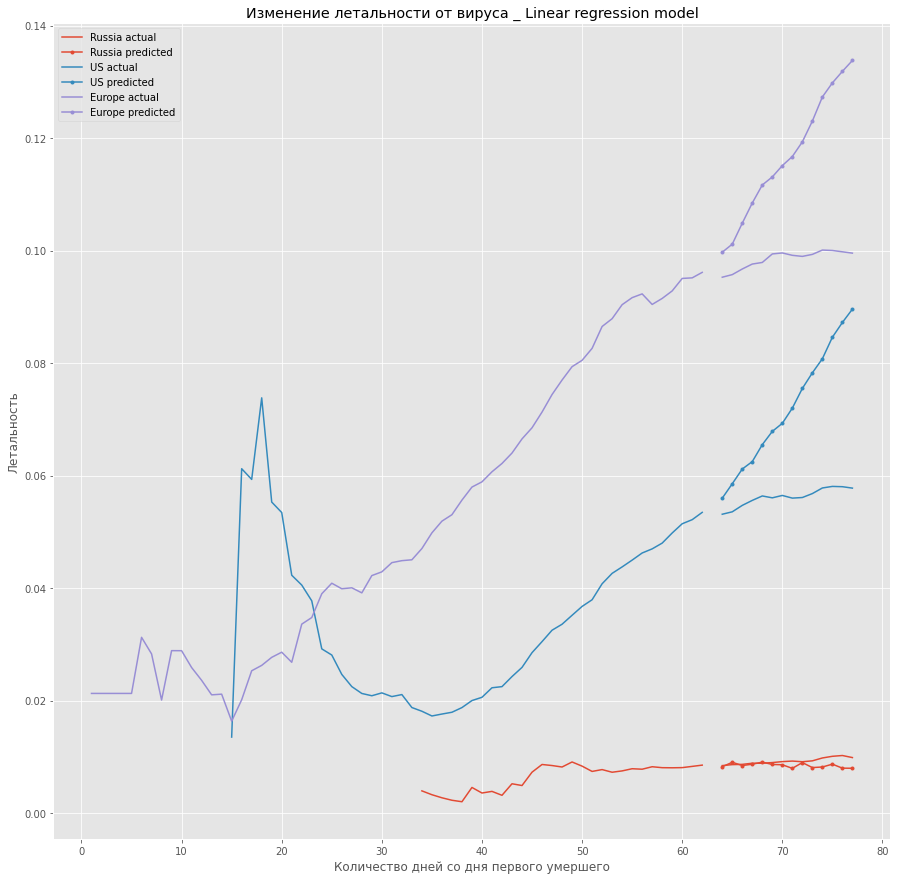

In [0]:
for k, v in view.items():
    x_train = df_to_lagdf(view[k]['train'], k)
    x_test = df_to_lagdf(view[k]['test'], k)
    col = np.insert(x_train.columns[3:], 0, 'date')
    cols = ' + '.join(col)

    linear_model = smfa.ols(f'target ~ {cols}', data = x_train).fit()
    print(k, linear_model.params)
    
    view[k]['train_cat'] = view[k]['train'].copy() 
    for i in tqdm_notebook(range(15)):
        df = df_to_lagdf(view[k]['train_cat'], k).tail(1)
        proba = linear_model.predict(df[col])
        view[k]['train_cat'] = pd.concat([view[k]['train_cat'], pd.DataFrame([
                                                                          {'Date': view[k]['train_cat']['Date'].max() + dt.timedelta(1), 
                                                                           'lag_cfr': proba.values[0]
                                                                           }])]).reset_index(drop=True)

    color = plt.plot(x_train['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], x_train['target']), label=f'{k} actual')[0].get_color()


    plt.plot(x_test['date'], lag_to_value(view[k]['train'].tail(1)['cfr'].values[0], x_test['target']), color=color)
    plt.plot(x_test['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], view[k]['train_cat']['lag_cfr'][1:])[-14:], c=color, marker='.', label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ Linear regression model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'Linear regression '}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(lag_to_value(view[k]['train'].loc[0, 'cfr'], view[k]['train_cat']['lag_cfr'][1:])[-15:], v['test']['cfr'])
value_

{'Europe RMSE': 0.019198688023777406,
 'Model': 'Linear regression ',
 'Russia RMSE': 0.001052785053035398,
 'US RMSE': 0.01701213946068173}

Если строить зависимость от количества подтвержденных и умерших, то получается не очень хорошо для России, т.к. недавно был скачок прироста подтвержденных случаев, и модель это учла, хотя смертность не поменялась. Но для остальных стран эти признаки считаются несущественными, и ряд апроксимируется практически линейной моделью.

Russia Intercept    0.002710
timeIndex    0.000409
Confirmed   -0.000002
Deaths       0.000251
dtype: float64
US Intercept    0.049313
timeIndex   -0.001650
Confirmed    0.000000
Deaths      -0.000001
dtype: float64
Europe Intercept    0.018934
timeIndex    0.000583
Confirmed    0.000000
Deaths      -0.000000
dtype: float64


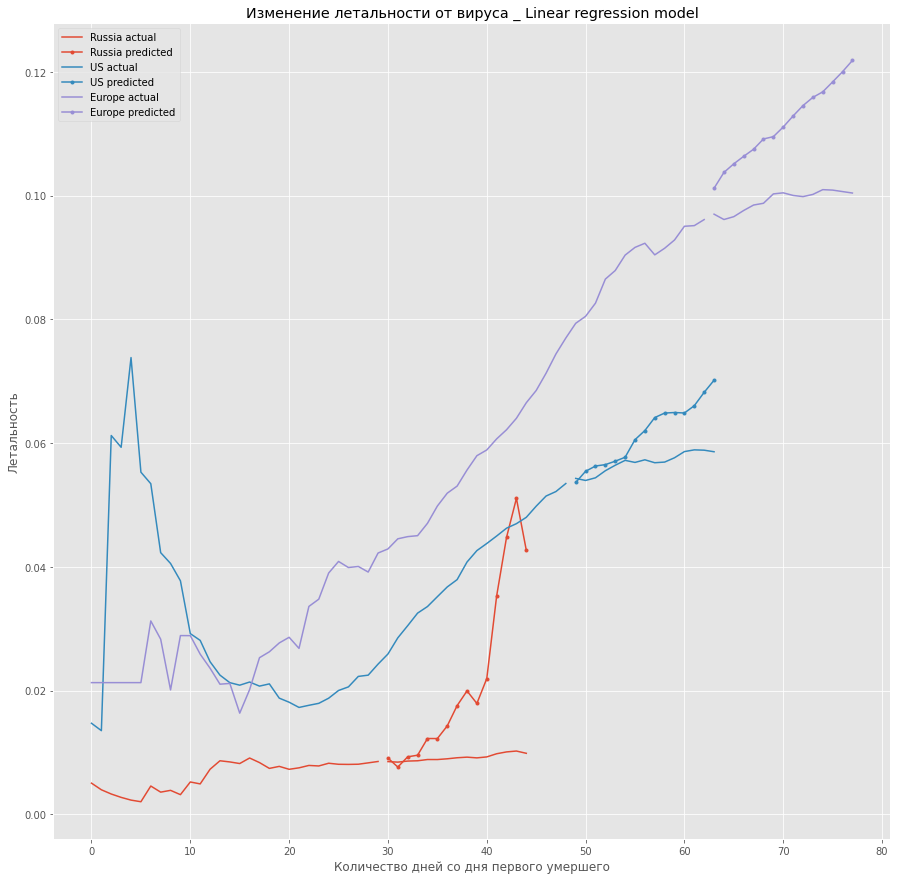

In [0]:
for k, v in view.items():
    linear_model = smfa.ols('cfr ~ timeIndex + Confirmed + Deaths', data = v['train']).fit()
    print(k, linear_model.params)
    v['linear_reg'] = {'test' : linear_model.predict(v['test'][['timeIndex', 'Confirmed', 'Deaths']])}
    color = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=color)
    plt.plot(range(len(v['train']['cfr']), len(v['train']['cfr']) + len(v['test']['cfr'])), v['linear_reg']['test'], c=color, marker='.', label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ Linear regression model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'Linear regression model 2'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(v['linear_reg']['test'], v['test']['cfr'])
value_

{'Europe RMSE': 0.013246924568182834,
 'Model': 'Linear regression model 2',
 'Russia RMSE': 0.018398626197265015,
 'US RMSE': 0.0059133500677440365}

2.11 (Бонус) Используйте любую другую известную вам модель для предсказания.


Используем Catboost на лагах, дате, дне недели и стране. Важно, что для всех стран одна модель. Поэтому паттерн роста у всех стран в итоге примерно одинаковый.

In [0]:
!pip install -q catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 64.8MB 59kB/s 


In [0]:
def predict_n_days(clf, n_days):
    for k, v in view.items():
        view[k]['train_cat'] = view[k]['train'].copy() 
    for i in tqdm_notebook(range(n_days)):
        df = pd.concat([df_to_lagdf(v['train_cat'], k).tail(1) for k, v in view.items()])
        probas = clf.predict(df)
        for proba, (k, v) in zip(probas, view.items()):
            view[k]['train_cat'] = pd.concat([view[k]['train_cat'], pd.DataFrame([
                                                                          {'Date': view[k]['train_cat']['Date'].max() + dt.timedelta(1), 
                                                                           'lag_cfr': proba
                                                                           }])]).reset_index(drop=True)

In [0]:
x_train = pd.concat([df_to_lagdf(view[k]['train'], k) for k, v in view.items()])
y_train = x_train['target']
x_train.drop(columns=['target'], inplace=True)

x_test = pd.concat([df_to_lagdf(view[k]['test'], k) for k, v in view.items() ])
y_test = x_test['target']
x_test.drop(columns=['target'], inplace=True)

In [0]:
clf = CatBoostRegressor(iterations=1000, cat_features=['country'], eval_metric='RMSE')
clf.fit(x_train, y_train, verbose=0)
# clf.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)

In [0]:
predict_n_days(clf, 15)

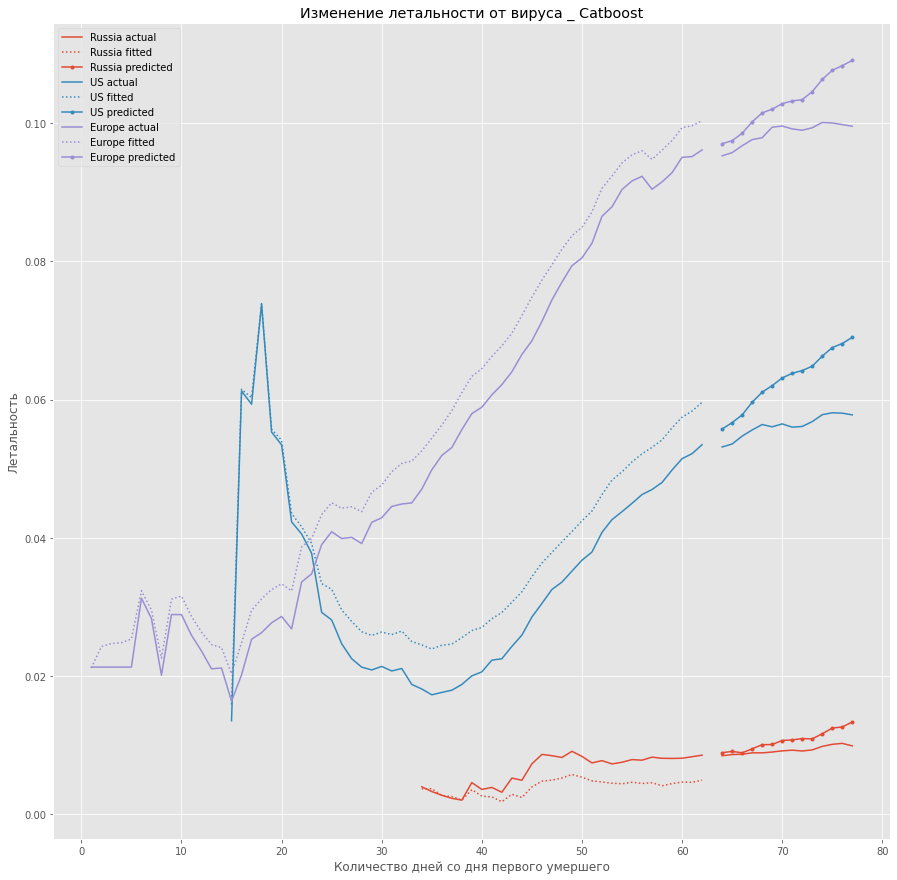

In [0]:
for k, v in view.items():
    x_tr = x_train['country'] == k
    x_te = x_test['country'] == k
    color = plt.plot(x_train[x_tr]['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], y_train[x_tr]), label=f'{k} actual')[0].get_color()
    plt.plot(x_train[x_tr]['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], clf.predict(x_train[x_tr])), c=color, linestyle=':', label=f'{k} fitted')


    plt.plot(x_test[x_te]['date'], lag_to_value(view[k]['train'].tail(1)['cfr'].values[0], y_test[x_te]), color=color)
    plt.plot(x_test[x_te]['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], view[k]['train_cat']['lag_cfr'][1:])[-sum(x_te):], c=color, marker='.', label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ Catboost')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()



In [0]:
value_ =  {'Model': 'Catboost'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(lag_to_value(view[k]['train'].loc[0, 'cfr'], view[k]['train_cat']['lag_cfr'][1:])[-15:], v['test']['cfr'])
value_

{'Europe RMSE': 0.004245742646815384,
 'Model': 'Catboost',
 'Russia RMSE': 0.0016554854219711435,
 'US RMSE': 0.006209360502681088}

Попробуем аппроксимировать ряд линейной моделью. Для каждой страны построим свою модель.

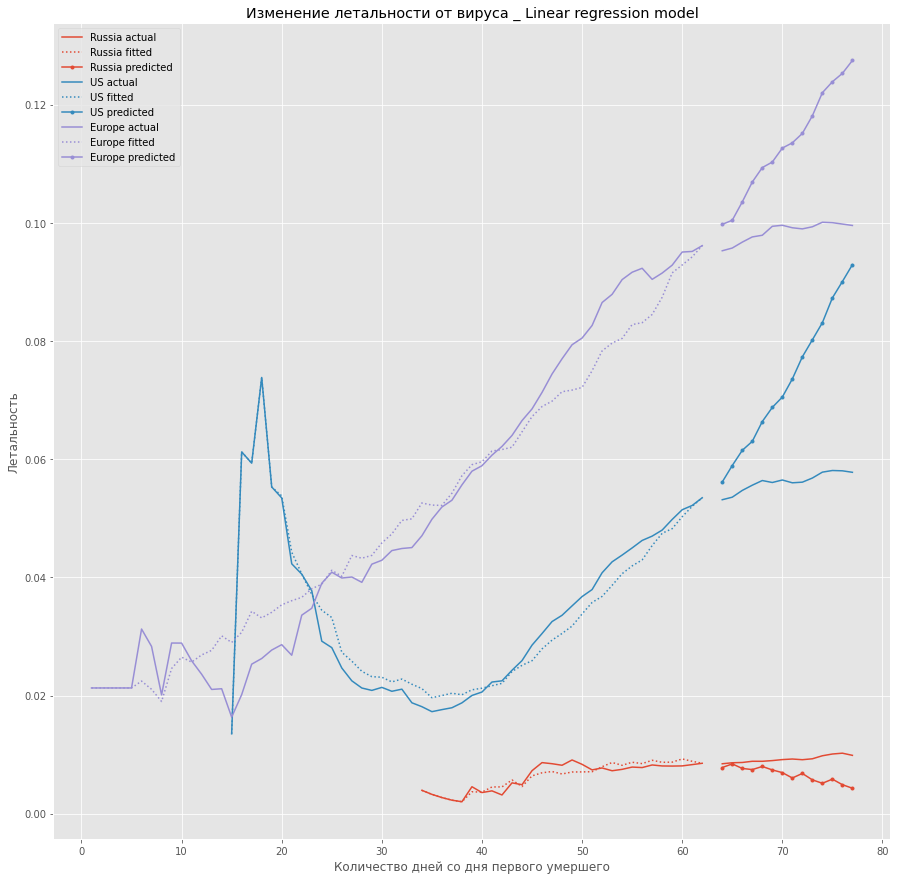

In [0]:
from sklearn.linear_model import LinearRegression
for k, v in view.items():
    x_train = df_to_lagdf(view[k]['train'], k).fillna(0)
    y_train = x_train['target']
    x_train.drop(columns=['target'], inplace=True)
    x_test = df_to_lagdf(view[k]['test'], k).fillna(0)
    y_test = x_test['target']
    x_test.drop(columns=['target'], inplace=True)
    col = x_train.columns[3:]

    clf = LinearRegression()
    clf.fit(X=x_train[col], y=y_train)
    
    view[k]['train_cat'] = view[k]['train'].copy() 
    for i in tqdm_notebook(range(15)):
        df = df_to_lagdf(view[k]['train_cat'], k).tail(1)
        proba = clf.predict(df[col])
        view[k]['train_cat'] = pd.concat([view[k]['train_cat'], pd.DataFrame([
                                                                          {'Date': view[k]['train_cat']['Date'].max() + dt.timedelta(1), 
                                                                           'lag_cfr': proba[0]
                                                                           }])]).reset_index(drop=True)

    color = plt.plot(x_train['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], y_train), label=f'{k} actual')[0].get_color()
    plt.plot(x_train['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], clf.predict(x_train[col])), c=color, linestyle=':', label=f'{k} fitted')


    plt.plot(x_test['date'], lag_to_value(view[k]['train'].tail(1)['cfr'].values[0], y_test), color=color)
    plt.plot(x_test['date'], lag_to_value(view[k]['train'].loc[0, 'cfr'], view[k]['train_cat']['lag_cfr'][1:])[-14:], c=color, marker='.', label=f'{k} predicted')

plt.legend()
plt.title('Изменение летальности от вируса _ Linear regression model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

In [0]:
value_ =  {'Model': 'Linear regression (Sklearn)'}
for k, v in view.items():
    value_[f'{k} RMSE'] = rmse(lag_to_value(view[k]['train'].loc[0, 'cfr'], view[k]['train_cat']['lag_cfr'][1:])[-15:], v['test']['cfr'])
value_

{'Europe RMSE': 0.01536430613272489,
 'Model': 'Linear regression (Sklearn)',
 'Russia RMSE': 0.0030292225411557134,
 'US RMSE': 0.01873602735290426}

Интересно, что есть возможность аппроксимировать ряд конечным множеством констант - состояний. Например, если эпидемия будет повторяться, то можно предсказывать, когда в стране пройдет эпидемия, когда в стране будет пик и сколько эти состояния будут продолжаться. К сожалению, функция предсказания в библиотеке еще не реализована.

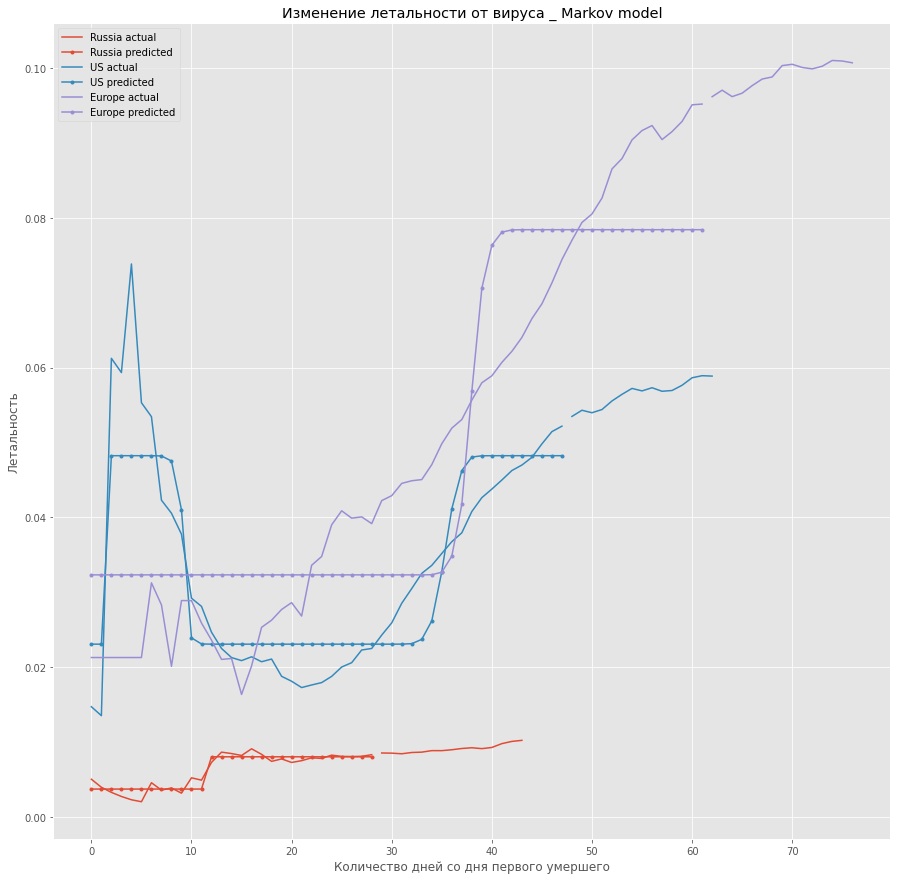

In [0]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

for k, v in view.items():
    model = MarkovRegression(v['train']['cfr'], 2)
    model_fit = model.fit()
    v['markov'] = {'test' : model_fit.predict()}
    color = plt.plot(v['train']['cfr'], label=f'{k} actual')[0].get_color()
    plt.plot(v['test']['cfr'], color=color)
    plt.plot(v['markov']['test'], c=color, marker='.', label=f'{k} predicted')


plt.legend()
plt.title('Изменение летальности от вируса _ Markov model')
plt.ylabel('Летальность')
plt.xlabel('Количество дней со дня первого умершего')
plt.show()

#### 2.11 Выводы

Модели, не предназначенные напрямую для временных рядов, показывают себя не очень хорошо (визуально можно определить сильные несовпадения). Хотя они в редких случаях могут показывать себя лучше неправильно подобранных специализированных моделей для рядов. В таких моделях можно учитывать несколько признаков (даже категориальных), что может помочь точности. Также такие модели могут служить и для других более специфичных задач, как например, модель Маркова для определения и предсказания состояний эпидемии в стране.

## Выводы по работе
Таким образом мы определили наиболее оптимальные модели для каждого рассматриваемого ряда. Модели получились разные, потому что все ряды сильно друг от друга отличаются.

Ошибка для ряда России самая маленькая, т.к. и значения летальности для нее самые маленькие. Ошибку для Европы и США удалось сильно уменьшить до того же порядка.

In [0]:
for c in results.columns[1:]:
    print(c, results.iloc[results[c].argmin(), 0], results[c].min())

Russia RMSE ARIMA(0, 0, 3) 0.00020791208695892586
US RMSE SARIMA(3, 1, 2) 0.000542061243726517
Europe RMSE SARIMA(3, 0, 2) 0.0005602831546130335
